In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd
import pandas as pd
import smps
import numpy as np
import joblib
import json
import seaborn as sns
import seaborn.objects as so
import plotly as py
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot
from matplotlib.markers import MarkerStyle
from matplotlib.lines import Line2D
from smps.fit import LogNormal
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.ticker import FuncFormatter
sns.set("notebook", "ticks", palette='Paired') 
%matplotlib inline

# 1. Read in Processced Data (No fogging, Shortened)

## 1.1 Timeseries files (already resampled to 6 min)

In [23]:
folder = '/Users/zahrashivji/Dropbox/Shivji/Final Data/Indoor Files/Short/Final/Shortened/'

data = dd.read_csv(
    folder + 'timeseries_forIgor_Nofogging_Shortened.csv',
    parse_dates=['timestamp']
).compute()

# Set the index to be the timestamp
data.set_index("timestamp", inplace=True) 

In [24]:
data.columns

Index(['Median (nm)', 'Mean (nm)', 'Mode (nm)', 'Geo. Mean (nm)', 'PM1_SMPS',
       'PM_350_SMPS', 'PM_300_SMPS', '% > 350nm', '% > 300nm', 'PM1_modpm',
       'PM25_modpm', 'PM10_modpm', 'PM1-25_modpm', 'PM25-10_modpm',
       'PM1_frac_modpm', 'PM25_frac_modpm', 'PM10_frac_modpm', 'PM1_neph',
       'PM25_neph', 'PM10_neph', 'PM1-25_neph', 'PM25-10_neph',
       'PM1_frac_neph', 'PM25_frac_neph', 'PM10_frac_neph', 'PM25/PM1_neph',
       'PM25/PM1_modpm', 'PMS PM1 bias', 'modpm PM1 bias', 'temp', 'rh',
       'class_time', 'obseved_class', 'fogging_mask'],
      dtype='object')

## 1.2 Bias Plot files 

### 1.2.1 Geo. Mean Diameter (GM)

In [603]:
gm = dd.read_csv(
    folder + 'gm_noFogging_forIgor_Shortened.csv'
).compute()

### 1.2.2 Relative Humidity (RH)

In [604]:
rh = dd.read_csv(
    folder + 'rh_noFogging_forIgor_Shortened.csv'
).compute()

### 1.2.3 SMPS PM1 Mass Loading (ML)

In [605]:
ml = dd.read_csv(
    folder + 'ml_noFogging_forIgor_Shortened.csv'
).compute()

## 1.3 SMPS

In [25]:
folder = '/Users/zahrashivji/Dropbox/Shivji/Final Data/Indoor Files/Short/Raw/'

df2 = pd.read_csv(
    folder + 'SMPS_Number_Klaus_Indoor.csv',
    skiprows = 25
)

def isfloat(str):
    try:
        float(str)
        return True
    except ValueError:
        return False

#Determine the total number of channels
n_channels = sum([isfloat(x) for x in df2.columns])

#Next determine the index of the first channel
channel0_idx = [i for i, x in enumerate([isfloat(x) for x in df2.columns]) if x][0]

#Convert to a datetime object
df2['timestamp']=df2['Date'].map(pd.to_datetime)

#Grab the bin diameters
midpoints = df2.columns[channel0_idx:channel0_idx+n_channels]
binlabels = ['bin{}'.format(i) for i in range(n_channels)]

#Rename the columns to bin<X>
df2.rename(columns=dict(zip(midpoints,binlabels)),inplace=True)

#Set the index for the data dataframe
df2.set_index('timestamp',inplace=True)


#Specify start and end date of interest
t0= "2022-04-08 00:00" #shortened time of interest, starting after 4/7 peak
tf = "2022-04-12 19:00"

df2 = df2[t0:tf].copy()

# Resample to a 5 min timebase
df2 = df2.resample('6min').mean()

# Build out a nx3 array of the bin boundaries
bins = smps.utils.make_bins(
    midpoints=midpoints,
    lb = df2['Lower Size (nm)'][0],
    ub = df2['Upper Size (nm)'][0],
    channels_per_decade=64,
)

#B uild a generic Particle Sizer Object 
obj = smps.GenericParticleSizer(
    data=df2.copy(),
    bins=bins,
    fmt='dn',
    dp_units='nm',
    bin_labels=binlabels
)

# 2. Plots

In [26]:
folder = "/Users/zahrashivji/Dropbox/Shivji/Final Figures/Indoor/"

## 2.1 Timeseries

In [566]:
# # set the label fontsize
# xy_label_fontsize = 12

# force 'normal' text style for math text
mpl.rcParams['mathtext.default'] = 'regular'

def major_ticks(x, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    x = mdates.num2date(x)
    if pos == 0:
        fmt = "%-d\n%-m\n%I\n%-M"
    else:
        fmt = "%-d"
    return x.strftime(fmt)

# set global seaborn params
sns.set("paper", "ticks", color_codes=True, palette='Paired')

# set up the matplotlib figure
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 8), edgecolor  = 'black', sharex=True)

# grab the current color palette
cmap = sns.color_palette("Paired")

# plot the PM10 data
ax[0].plot(data['PM10_modpm'], lw=1.5, label="MODULAIR-PM", color=cmap[7])
ax[0].plot(data['PM10_neph'], lw=1.5, label='PMS', color=cmap[6])
ax[0].set_ylabel("$PM_10 \; [\mu g m^{-3}]$")
ax[0].set_ylim(-0.1, None)
ax[0].set_xlim('04-08-2022 00:00', '04-12-2022 06:54')
ax[0].legend(loc = 'upper left')

# plot the o3, so2, and no2 data on the second axis
ax[1].plot(data['PM25_modpm'], lw=1.5, label="MODULAIR-PM", color=cmap[3])
ax[1].plot(data['PM25_neph'], lw=1.5, label='PMS', color=cmap[2])
ax[1].set_ylabel("$PM_2.5 \; [\mu g m^{-3}]$")
ax[1].set_ylim(-0.1, None)
ax[1].legend(loc = 'upper left')

# plot the OPC bins on the third row (Of MODULAIR)
ax[2].plot(data['PM1_modpm'], lw=1.5, label="MODULAIR-PM", color=cmap[1])
ax[2].plot(data['PM1_neph'], lw=1.5, label='PMS', color=cmap[0])
ax[2].plot(data['PM1_SMPS'], lw=1.5, label='SMPS', color='darkgray', linestyle='dashed')
ax[2].set_ylabel("$PM_1 \; [\mu g m^{-3}]$")
ax[2].set_ylim(-0.1, None)
ax[2].legend(loc = 'upper left')

# # label the panels
# pct = 0.9
# ax[0].text("04-08 00", pct*ax[0].get_ylim()[-1], "(a)")
# ax[1].text("04-08 00", pct*ax[1].get_ylim()[-1], "(b)")
# ax[2].text("04-08 00", pct*ax[2].get_ylim()[-1], "(c)")

# set titles for each panel
ax[0].set_title("PM10", fontsize=12)
ax[1].set_title("PM2.5", fontsize=12)
ax[2].set_title("PM1", fontsize=12)

# # remove the tiop and right spine
# sns.despine()

# force a tight layout
plt.tight_layout()

# # save the figure
# fig.savefig(folder+'timeseries_whole_period.png', dpi=350, bbox_inches='tight')

fig.show()
plt.close(fig)

/var/folders/3x/bzpq51ls1_q2l69w2sj38xym0000gn/T/ipykernel_37869/2547686538.py:70: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



In [567]:
# # set the label fontsize
# xy_label_fontsize = 12

# force 'normal' text style for math text
mpl.rcParams['mathtext.default'] = 'regular'

def x_major_ticks(x, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    x = mdates.num2date(x)
    fmt = "%a %-m-%-d \n%I:%M %p"
    
    return x.strftime(fmt)

def y_major_ticks(y, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    y = int(y)
    
    return y

# set global seaborn params
sns.set("paper", "ticks", color_codes=True, palette='Paired')

# set up the matplotlib figure
fig, ax = plt.subplots(figsize = [8.5, 3.5], dpi = 350)

# grab the current color palette
cmap = sns.color_palette("Paired")

# plot the PM1 data
plt.plot(data['PM1_modpm'], lw=1.5, label="MODULAIR-PM", color=cmap[1])
plt.plot(data['PM1_neph'], lw=1.5, label='PMS', color=cmap[0])
plt.plot(data['PM1_SMPS'], lw=1.5, label='SMPS', color='darkgray', linestyle='dashed')
plt.ylabel("$PM_{1} \; [\mu g m^{-3}]$")
plt.xlim('04-08-2022 00:00', '04-12-2022 06:54')
plt.legend(loc = 'upper left')

ax.xaxis.set_major_formatter(x_major_ticks)
ax.yaxis.set_major_formatter(y_major_ticks)

# # remove the tiop and right spine
# sns.despine()

# force a tight layout
plt.tight_layout()

# save the figure
plt.savefig(
    folder + "Timeseries_PM1.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
plt.close(fig)

In [568]:
# # set the label fontsize
# xy_label_fontsize = 12

# force 'normal' text style for math text
mpl.rcParams['mathtext.default'] = 'regular'

def x_major_ticks(x, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    x = mdates.num2date(x)
    fmt = "%a %-m-%-d \n%I:%M %p"
    
    return x.strftime(fmt)

def y_major_ticks(y, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    y = int(y)
    
    return y

# set global seaborn params
sns.set("paper", "ticks", color_codes=True, palette='Paired')

# set up the matplotlib figure
fig, ax = plt.subplots(figsize = [8.5, 3.5], dpi = 350)

# grab the current color palette
cmap = sns.color_palette("Paired")

# plot the PM10 data
plt.plot(data['PM25_modpm'], lw=1.5, label="MODULAIR-PM", color=cmap[3])
plt.plot(data['PM25_neph'], lw=1.5, label='PMS', color=cmap[2])
plt.ylabel("$PM_{2.5} \; [\mu g m^{-3}]$")
plt.xlim('04-08-2022 00:00', '04-12-2022 06:54')
plt.legend(loc = 'upper left')

ax.xaxis.set_major_formatter(x_major_ticks)
ax.yaxis.set_major_formatter(y_major_ticks)

# # remove the tiop and right spine
# sns.despine()

# force a tight layout
plt.tight_layout()

# save the figure
plt.savefig(
    folder + "Timeseries_PM25.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
plt.close(fig)

In [569]:
# # set the label fontsize
# xy_label_fontsize = 12

# force 'normal' text style for math text
mpl.rcParams['mathtext.default'] = 'regular'

def x_major_ticks(x, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    x = mdates.num2date(x)
    fmt = "%a %-m-%-d \n%I:%M %p"
    
    return x.strftime(fmt)

def y_major_ticks(y, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    y = int(y)
    
    return y

# set global seaborn params
sns.set("paper", "ticks", color_codes=True, palette='Paired')

# set up the matplotlib figure
fig, ax = plt.subplots(figsize = [8.5, 3.5], dpi = 350)

# grab the current color palette
cmap = sns.color_palette("Paired")

# plot the PM10 data
plt.plot(data['PM10_modpm'], lw=1.5, label="MODULAIR-PM", color=cmap[7])
plt.plot(data['PM10_neph'], lw=1.5, label='PMS', color=cmap[6])
plt.ylabel("$PM_{10} \; [\mu g m^{-3}]$")
plt.xlim('04-08-2022 00:00', '04-12-2022 06:54')
plt.legend(loc = 'upper left')

ax.xaxis.set_major_formatter(x_major_ticks)
ax.yaxis.set_major_formatter(y_major_ticks)

# # remove the tiop and right spine
# sns.despine()

# force a tight layout
plt.tight_layout()

# save the figure
plt.savefig(
    folder + "Timeseries_PM10.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
plt.close(fig)

## 2.2 Scatter Plots

### 2.2.1 PM1 

In [27]:
import statsmodels.formula.api as smf

dat = data

results = smf.ols("PM1_modpm ~ PM1_SMPS",data=dat).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              PM1_modpm   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                 1.597e+04
Date:                Sat, 05 Nov 2022   Prob (F-statistic):               0.00
Time:                        12:42:40   Log-Likelihood:                 33.817
No. Observations:                 975   AIC:                            -63.63
Df Residuals:                     973   BIC:                            -53.87
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2021      0.013    -15.253      0.0

In [28]:
import statsmodels.formula.api as smf

dat = data

results = smf.ols("PM1_neph ~ PM1_SMPS",data=dat).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               PM1_neph   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     3081.
Date:                Sat, 05 Nov 2022   Prob (F-statistic):          8.40e-304
Time:                        12:42:41   Log-Likelihood:                -60.253
No. Observations:                 975   AIC:                             124.5
Df Residuals:                     973   BIC:                             134.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4251      0.015    -29.134      0.0

In [29]:
import statsmodels.formula.api as smf

dat = data

results = smf.ols("PM1_neph ~ PM1_modpm",data=dat).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               PM1_neph   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     5590.
Date:                Sat, 05 Nov 2022   Prob (F-statistic):               0.00
Time:                        12:42:42   Log-Likelihood:                 175.79
No. Observations:                 982   AIC:                            -347.6
Df Residuals:                     980   BIC:                            -337.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3426      0.010    -33.790      0.0

In [30]:
x_smps = [data['PM1_SMPS'].min(), data['PM1_SMPS'].max()]
y_neph = [data['PM1_SMPS'].min()*0.3569-0.4251, data['PM1_SMPS'].max()*0.3569-0.4251]
y_modpm = [data['PM1_SMPS'].min()*0.7378 -0.2021, data['PM1_SMPS'].max()*0.7378 -0.2021]

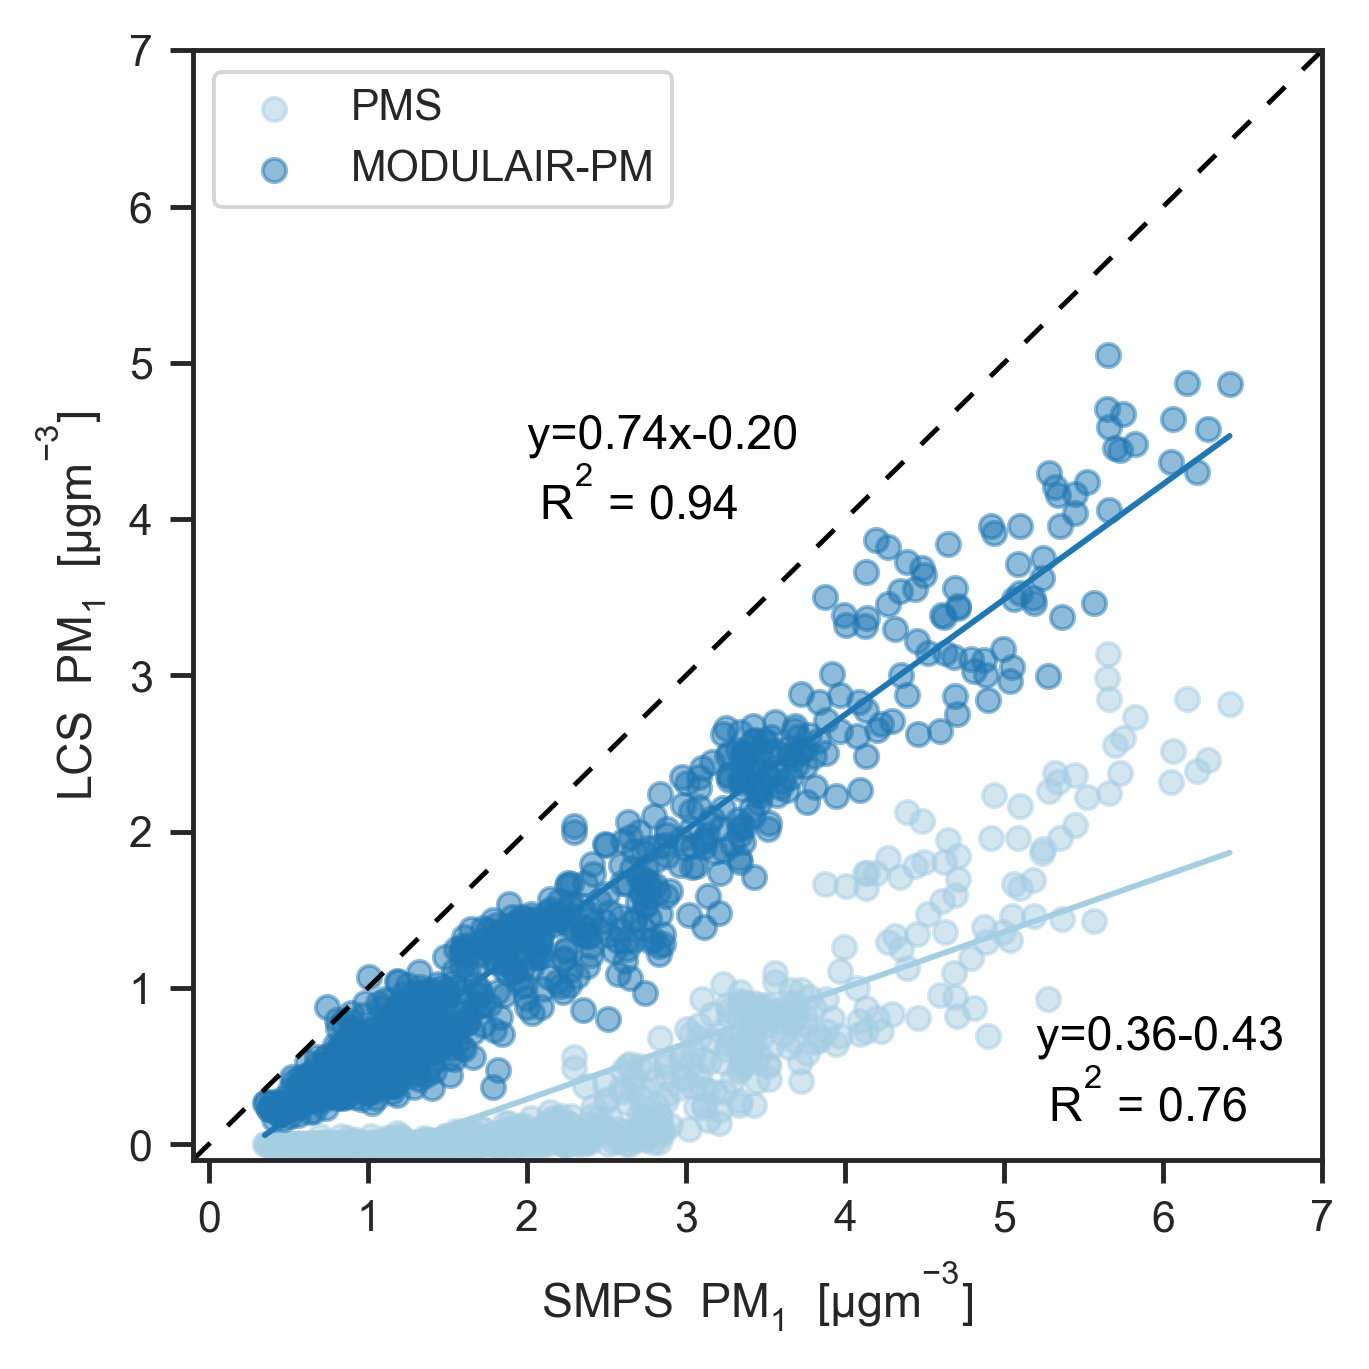

In [573]:
folder = "/Users/zahrashivji/Dropbox/Shivji/Final Figures/Indoor/"

fig = plt.figure(figsize = [4, 4], dpi = 350)

cmap = sns.color_palette("Paired")

# Add scatter points
plt.scatter(
    data["PM1_SMPS"], 
    data["PM1_neph"], 
    marker = MarkerStyle('o'),
    alpha = 0.5,
    color = cmap[0],
    label = 'PMS')

# Add scatter points
plt.scatter(
    data["PM1_SMPS"], 
    data["PM1_modpm"], 
    marker = MarkerStyle('o'),
    alpha = 0.5,
    color = cmap[1],
    label = 'MODULAIR-PM')

# Add x=y line
plt.axline(
    [0, 0],
    [1, 1],
    c = 'black',
    dashes = (5, 5), lw= 1)

# Add ols trendline
plt.plot(
    x_smps,
    y_neph,
    color = cmap[0])

# Add ols trendline
plt.plot(
    x_smps,
    y_modpm,
    color = cmap[1])

plt.xlabel("SMPS  " + "$PM_{1}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylabel("LCS  " + "$PM_{1}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylim(-0.1, 7)
plt.xlim(-0.1, 7)
plt.legend(loc = 'upper left')
plt.annotate('y=0.36-0.43 \n $R^2$ = 0.76', (5.2,0.15), c = 'black')
plt.annotate('y=0.74x-0.20 \n $R^2$ = 0.94', (2,4), c = 'black')

plt.tight_layout()

plt.savefig(
    folder + "Scatter_PM1.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
# plt.close(fig)

### 2.2.2 PM2.5

In [31]:
import statsmodels.formula.api as smf

dat = data

results = smf.ols("PM25_neph ~ PM25_modpm",data=dat).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              PM25_neph   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     8935.
Date:                Sat, 05 Nov 2022   Prob (F-statistic):               0.00
Time:                        12:42:48   Log-Likelihood:                 18.968
No. Observations:                 982   AIC:                            -33.94
Df Residuals:                     980   BIC:                            -24.16
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5589      0.013    -43.868      0.0

In [32]:
x_modpm_pm25 = [data['PM25_modpm'].min(), data['PM25_modpm'].max()]
y_neph_pm25 = [data['PM25_modpm'].min()*0.7458-0.5589, data['PM25_modpm'].max()*0.7458-0.5589]

In [576]:
folder = "/Users/zahrashivji/Dropbox/Shivji/Final Figures/Indoor/"

fig = plt.figure(figsize = [4, 4], dpi = 350)

cmap = sns.color_palette("Paired")

# Add scatter points
plt.scatter(
    data["PM25_modpm"], 
    data["PM25_neph"], 
    marker = MarkerStyle('o'),
    alpha = 0.3,
    color = cmap[3])

# Add x=y line
plt.axline(
    [0, 0],
    [1, 1],
    c = 'black',
    dashes = (5, 5), lw= 1)

# Add ols trendline
plt.plot(
    x_modpm_pm25,
    y_neph_pm25,
    color = cmap[3])

plt.xlabel("MODULAIR-PM  " + "$PM_{2.5}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylabel("PMS  " + "$PM_{2.5}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylim(-0.1, 5.25)
plt.xlim(-0.1, 5.25)
plt.annotate('y=0.75x-0.56 \n $R^2$ = 0.90', (1.5,3), c = cmap[3])

plt.tight_layout()

plt.savefig(
    folder + "Scatter_PM25.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
plt.close(fig)

### 2.2.3 PM10

In [33]:
import statsmodels.formula.api as smf

dat = data

results = smf.ols("PM10_neph ~ PM10_modpm",data=dat).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              PM10_neph   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     31.16
Date:                Sat, 05 Nov 2022   Prob (F-statistic):           3.08e-08
Time:                        12:42:52   Log-Likelihood:                -1171.6
No. Observations:                 982   AIC:                             2347.
Df Residuals:                     980   BIC:                             2357.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3083      0.038      8.091      0.0

In [34]:
x_modpm_pm10 = [data['PM10_modpm'].min(), data['PM10_modpm'].max()]
y_neph_pm10 = [data['PM10_modpm'].min()*0.0641+0.3083, data['PM10_modpm'].max()*0.0641+0.3083]

In [579]:
folder = "/Users/zahrashivji/Dropbox/Shivji/Final Figures/Indoor/"

def y_major_ticks(y, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    y = int(y)
    
    return y

fig, ax = plt.subplots(figsize = [4, 4], dpi = 350)

cmap = sns.color_palette("Paired")

# Add scatter points
plt.scatter(
    data["PM10_modpm"], 
    data["PM10_neph"], 
    marker = MarkerStyle('o'),
    alpha = 0.3,
    color = cmap[7])

# Add x=y line
plt.axline(
    [0, 0],
    [1, 1],
    c = 'black',
    dashes = (5, 5), lw= 1)

# Add ols trendline
plt.plot(
    x_modpm_pm10,
    y_neph_pm10,
    color = cmap[7])

plt.xlabel("MODULAIR-PM  " + "$PM_{10}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylabel("PMS  " + "$PM_{10}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylim(-0.5, 20)
plt.xlim(-0.5, 20)
plt.annotate('y=0.06x+0.31 \n $R^2$ = 0.03', (10,5), c = cmap[7])

ax.yaxis.set_major_formatter(y_major_ticks)

plt.tight_layout()

plt.savefig(
    folder + "Scatter_PM10.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
plt.close(fig)

## 2.3 Large Particle Plots 

### 2.3.1 PM2.5-PM1

In [580]:
# # set the label fontsize
# xy_label_fontsize = 12

# force 'normal' text style for math text
mpl.rcParams['mathtext.default'] = 'regular'

def x_major_ticks(x, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    x = mdates.num2date(x)
    fmt = "%a %-m-%-d \n%I:%M %p"
    
    return x.strftime(fmt)

def y_major_ticks(y, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    y = int(y)
    
    return y

# set global seaborn params
sns.set("paper", "ticks", color_codes=True, palette='Paired')

# set up the matplotlib figure
fig, ax = plt.subplots(figsize = [8.5, 3.5], dpi = 350)

# grab the current color palette
cmap = sns.color_palette("Paired")

# plot the PM10 data
plt.plot(data['PM1-25_modpm'], lw=1.5, label="MODULAIR-PM", color=cmap[3])
plt.plot(data['PM1-25_neph'], lw=1.5, label='PMS', color=cmap[2])
plt.ylabel("$PM_{1-2.5} \; [\mu g m^{-3}]$")
plt.xlim('04-08-2022 00:00', '04-12-2022 06:54')
plt.legend(loc = 'upper left')

ax.xaxis.set_major_formatter(x_major_ticks)

# # remove the tiop and right spine
# sns.despine()

# force a tight layout
plt.tight_layout()

# save the figure
plt.savefig(
    folder + "Timeseries_PM1-25.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
plt.close(fig)

In [581]:
import statsmodels.formula.api as smf

tmp = data.copy()[["PM1-25_neph" , "PM1-25_modpm"]]
tmp.rename(columns = {'PM1-25_neph':'PM1_25_neph', 'PM1-25_modpm':'PM1_25_modpm'}, inplace = True)

dat = tmp

results = smf.ols("PM1_25_neph ~ PM1_25_modpm",data=dat).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            PM1_25_neph   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     25.18
Date:                Tue, 01 Nov 2022   Prob (F-statistic):           6.21e-07
Time:                        09:17:34   Log-Likelihood:                -17.397
No. Observations:                 982   AIC:                             38.79
Df Residuals:                     980   BIC:                             48.57
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.2030      0.011     19.174   

In [582]:
x_modpm_pm1_25 = [data['PM1-25_modpm'].min(), data['PM1-25_modpm'].max()]
y_neph_pm1_25 = [data['PM1-25_modpm'].min()*-0.2925+0.2030, data['PM1-25_modpm'].max()*-0.2925+0.2030]

In [583]:
folder = "/Users/zahrashivji/Dropbox/Shivji/Final Figures/Indoor/"

fig = plt.figure(figsize = [4, 4], dpi = 350)

cmap = sns.color_palette("Paired")

# Add scatter points
plt.scatter(
    data["PM1-25_modpm"], 
    data["PM1-25_neph"], 
    marker = MarkerStyle('o'),
    alpha = 0.3,
    color = cmap[3])

# Add x=y line
plt.axline(
    [0, 0],
    [1, 1],
    c = 'black',
    dashes = (5, 5), lw= 1)

# Add ols trendline
plt.plot(
    x_modpm_pm1_25,
    y_neph_pm1_25,
    color = cmap[3])

plt.xlabel("MODULAIR-PM  " + "$PM_{1-2.5}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylabel("PMS  " + "$PM_{1-2.5}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylim(-0.05, 1.3)
plt.xlim(-0.05, 1.3)
plt.annotate('y = -0.29+0.20 \n $R^2$ = 0.03', (0.8,0.5), c = cmap[3])

plt.tight_layout()

plt.savefig(
    folder + "Scatter_PM1-25.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
plt.close(fig)

### 2.3.2 PM2.5-10

In [584]:
# force 'normal' text style for math text
mpl.rcParams['mathtext.default'] = 'regular'

def x_major_ticks(x, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    x = mdates.num2date(x)
    fmt = "%a %-m-%-d \n%I:%M %p"
    
    return x.strftime(fmt)

# set global seaborn params
sns.set("paper", "ticks", color_codes=True, palette='Paired')

# set up the matplotlib figure
fig, ax = plt.subplots(figsize = [8.5, 3.5], dpi = 350)

# grab the current color palette
cmap = sns.color_palette("Paired")

# plot the PM10 data
plt.plot(data['PM25-10_modpm'], lw=1.5, label="MODULAIR-PM", color=cmap[7])
plt.plot(data['PM25-10_neph'], lw=1.5, label='PMS', color=cmap[6])
plt.ylabel("$PM_{2.5-10} \; [\mu g m^{-3}]$")
plt.xlim('04-08-2022 00:00', '04-12-2022 06:54')
plt.legend(loc = 'upper left')

ax.xaxis.set_major_formatter(x_major_ticks)

# # remove the tiop and right spine
# sns.despine()

# force a tight layout
plt.tight_layout()

# save the figure
plt.savefig(
    folder + "Timeseries_PM25-10.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
plt.close(fig)

In [585]:
import statsmodels.formula.api as smf

tmp = data.copy()[["PM25-10_neph" , "PM25-10_modpm"]]
tmp.rename(columns = {'PM25-10_neph':'PM25_10_neph', 'PM25-10_modpm':'PM25_10_modpm'}, inplace = True)

dat = tmp

results = smf.ols("PM25_10_neph ~ PM25_10_modpm",data=dat).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           PM25_10_neph   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     21.91
Date:                Tue, 01 Nov 2022   Prob (F-statistic):           3.25e-06
Time:                        09:17:36   Log-Likelihood:                 1102.7
No. Observations:                 982   AIC:                            -2201.
Df Residuals:                     980   BIC:                            -2192.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0637      0.003     22.223

In [586]:
x_modpm_pm25_10 = [data['PM25-10_modpm'].min(), data['PM25-10_modpm'].max()]
y_neph_pm25_10 = [data['PM25-10_modpm'].min()*-0.0055+0.0637, data['PM25-10_modpm'].max()*-0.0055+0.0637]

In [587]:
folder = "/Users/zahrashivji/Dropbox/Shivji/Final Figures/Indoor/"

fig, ax = plt.subplots(figsize = [4, 4], dpi = 350)

cmap = sns.color_palette("Paired")

# Add scatter points
plt.scatter(
    data["PM25-10_modpm"], 
    data["PM25-10_neph"], 
    marker = MarkerStyle('o'),
    alpha = 0.3,
    color = cmap[7])

# Add x=y line
plt.axline(
    [0, 0],
    [1, 1],
    c = 'black',
    dashes = (5, 5), lw= 1)

# Add ols trendline
plt.plot(
    x_modpm_pm25_10,
    y_neph_pm25_10,
    color = cmap[7])

plt.xlabel("MODULAIR-PM  " + "$PM_{2.5-10}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylabel("PMS  " + "$PM_{2.5-10}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylim(-0.5, 20)
plt.xlim(-0.5, 20)
plt.annotate('y = -0.01+0.06 \n $R^2$ = 0.02', (10,5), c = cmap[7])

ax.yaxis.set_major_formatter(y_major_ticks)

plt.tight_layout()

plt.savefig(
    folder + "Scatter_PM25-10.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
plt.close(fig)

## 2.4 Colored by Observed Class Times

### 2.4.1 PM1

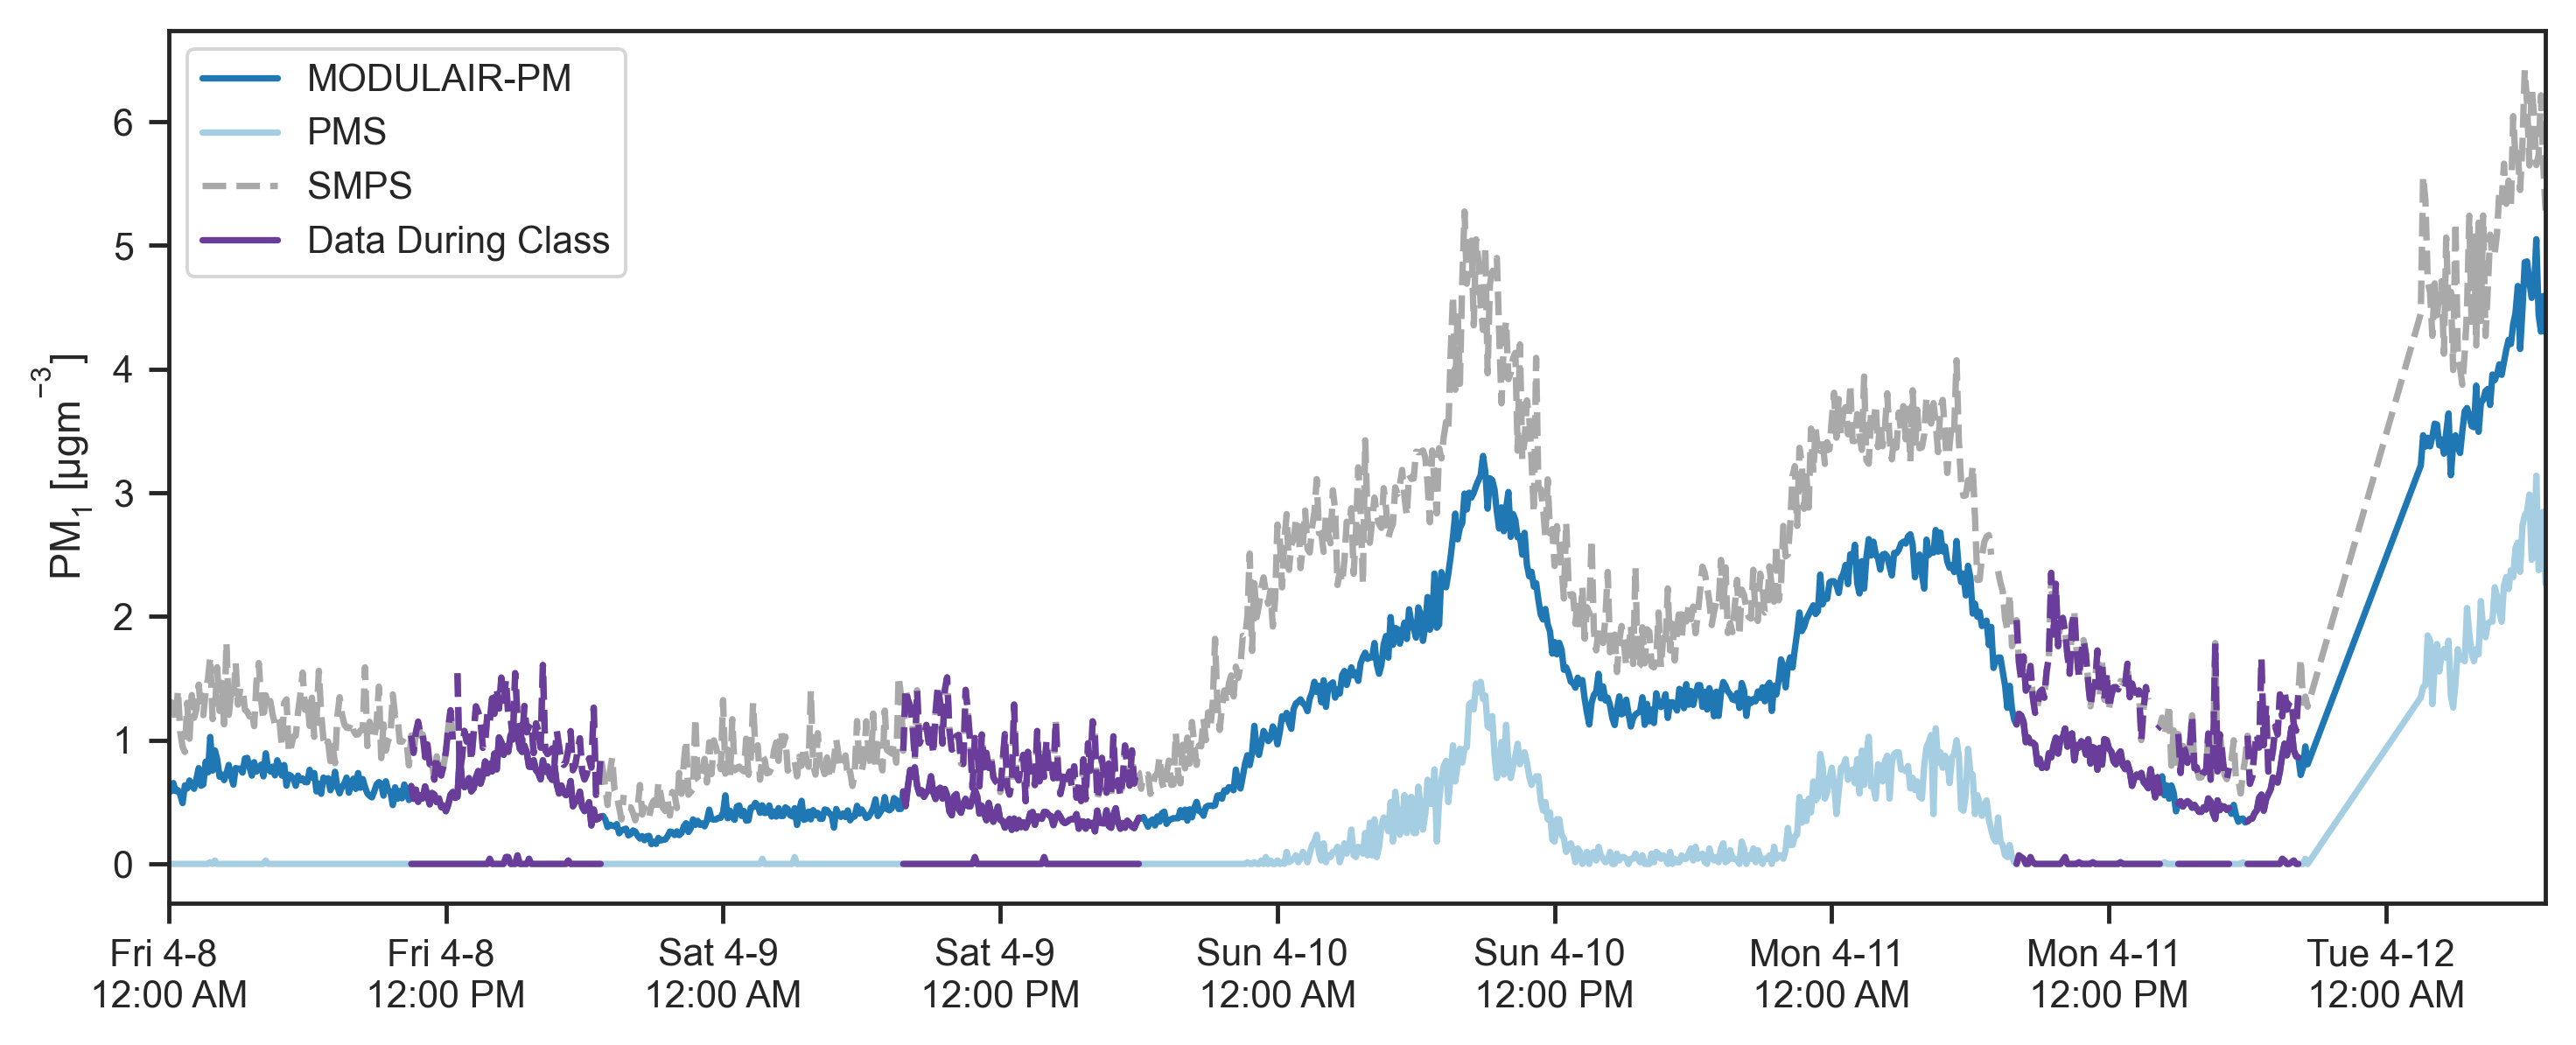

In [35]:
# # set the label fontsize
# xy_label_fontsize = 12

# force 'normal' text style for math text
mpl.rcParams['mathtext.default'] = 'regular'

def x_major_ticks(x, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    x = mdates.num2date(x)
    fmt = "%a %-m-%-d \n%I:%M %p"
    
    return x.strftime(fmt)

def y_major_ticks(y, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    y = int(y)
    
    return y

# set global seaborn params
sns.set("paper", "ticks", color_codes=True, palette='Paired')

# set up the matplotlib figure
fig, ax = plt.subplots(figsize = [8.5, 3.5], dpi = 350)

# grab the current color palette
cmap = sns.color_palette("Paired")

# plot the PM1 data
plt.plot(data['PM1_modpm'], lw=1.5, label="MODULAIR-PM", color=cmap[1])
plt.plot(data['PM1_neph'], lw=1.5, label='PMS', color=cmap[0])
plt.plot(data['PM1_SMPS'], lw=1.5, label='SMPS', color='darkgray', linestyle='dashed')

# overlay class time
plt.plot(data['PM1_modpm'].where(data['obseved_class']==1,  other =np.nan), lw=1.5, label = 'Data During Class', color=cmap[9])
plt.plot(data['PM1_neph'].where(data['obseved_class']==1,  other =np.nan), lw=1.5, label=None, color=cmap[9])
plt.plot(data['PM1_SMPS'].where(data['obseved_class']==1,  other =np.nan), lw=1.5, label=None, color=cmap[9], linestyle='dashed')

plt.ylabel("$PM_{1} \; [\mu g m^{-3}]$")
plt.xlim('04-08-2022 00:00', '04-12-2022 06:54')
plt.legend(loc = 'upper left')

ax.xaxis.set_major_formatter(x_major_ticks)
ax.yaxis.set_major_formatter(y_major_ticks)

# # remove the tiop and right spine
# sns.despine()

# force a tight layout
plt.tight_layout()

# save the figure
plt.savefig(
    folder + "Timeseries_PM1_Class.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
# plt.close(fig)

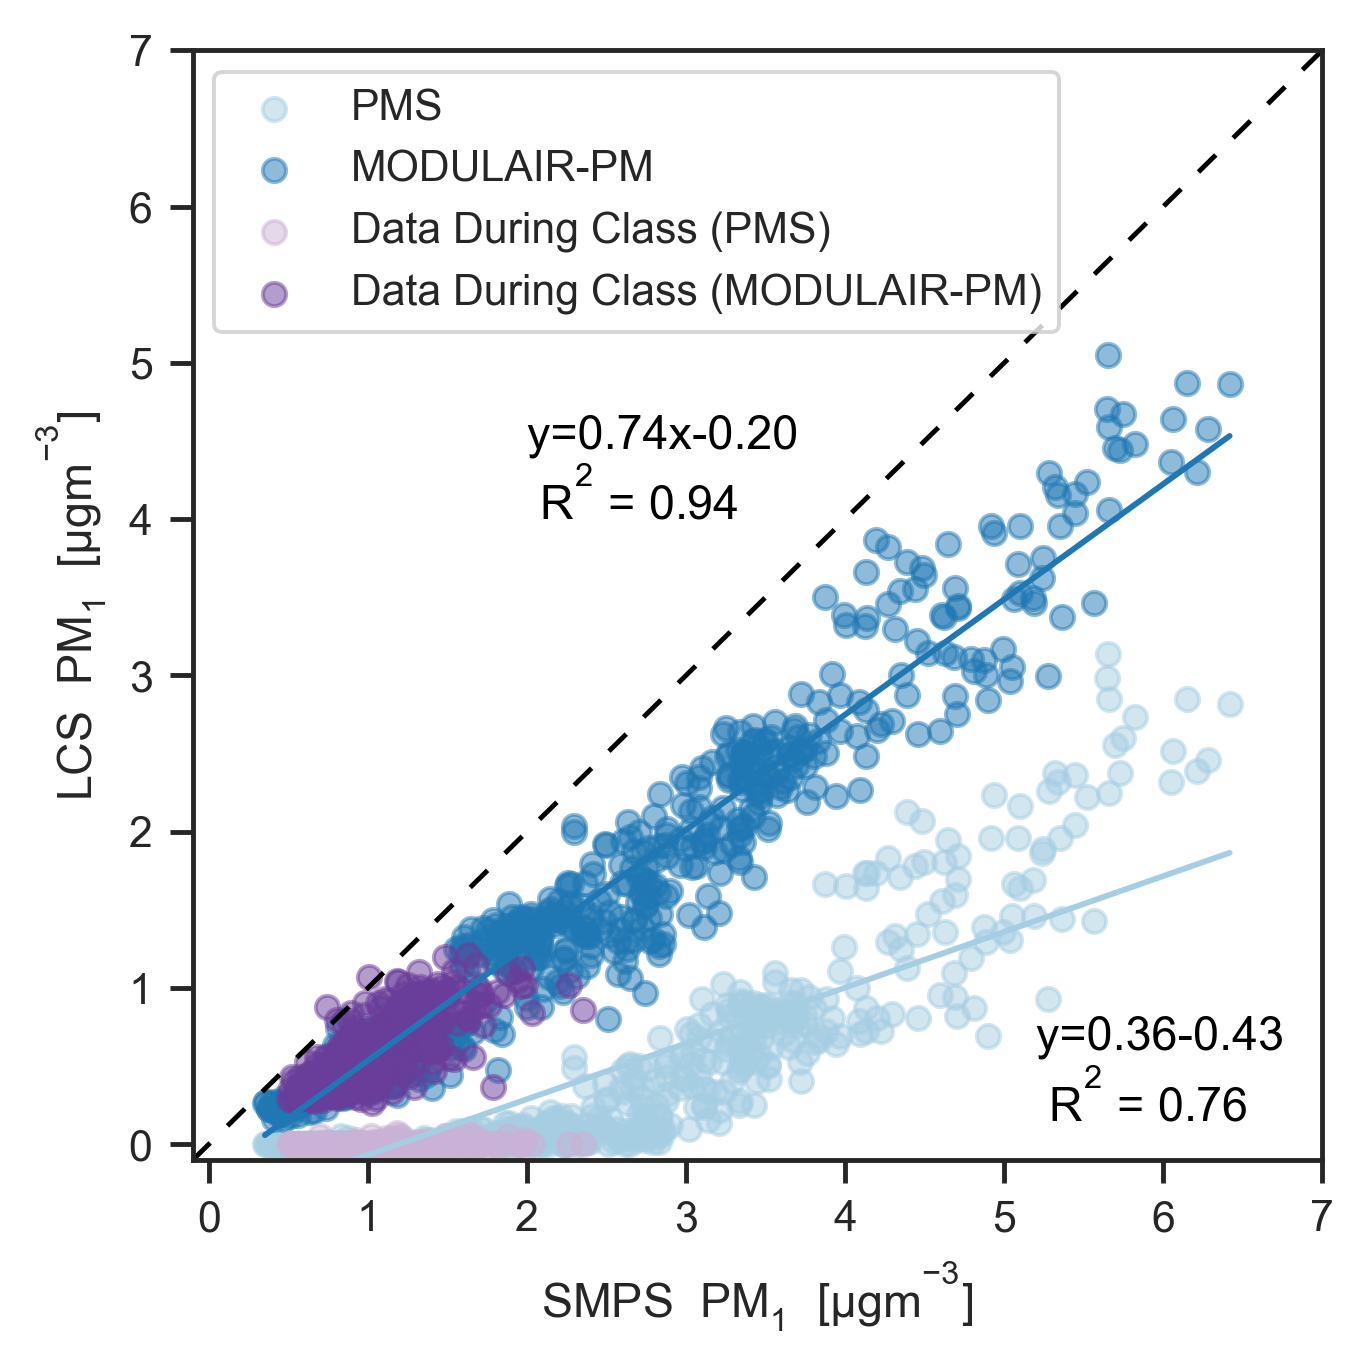

In [36]:
fig = plt.figure(figsize = [4, 4], dpi = 350)

cmap = sns.color_palette("Paired")

# Add scatter points
plt.scatter(
    data["PM1_SMPS"].where(data['obseved_class']==0), 
    data["PM1_neph"].where(data['obseved_class']==0), 
    marker = MarkerStyle('o'),
    alpha = 0.5,
    color = cmap[0],
    label = 'PMS')

plt.scatter(
    data["PM1_SMPS"].where(data['obseved_class']==0), 
    data["PM1_modpm"].where(data['obseved_class']==0), 
    marker = MarkerStyle('o'),
    alpha = 0.5,
    color = cmap[1],
    label = 'MODULAIR-PM')

# Add Class Coloring
plt.scatter(
    data["PM1_SMPS"].where(data['obseved_class']==1,  other =np.nan), 
    data["PM1_neph"].where(data['obseved_class']==1,  other =np.nan), 
    marker = MarkerStyle('o'),
    alpha = 0.5,
    color = cmap[8],
    label = 'Data During Class (PMS)')

plt.scatter(
    data["PM1_SMPS"].where(data['obseved_class']==1,  other =np.nan), 
    data["PM1_modpm"].where(data['obseved_class']==1,  other =np.nan), 
    marker = MarkerStyle('o'),
    alpha = 0.5,
    color = cmap[9],
    label = 'Data During Class (MODULAIR-PM)')

# Add x=y line
plt.axline(
    [0, 0],
    [1, 1],
    c = 'black',
    dashes = (5, 5), lw= 1)

# Add ols trendline
plt.plot(
    x_smps,
    y_neph,
    color = cmap[0])

# Add ols trendline
plt.plot(
    x_smps,
    y_modpm,
    color = cmap[1])

plt.xlabel("SMPS  " + "$PM_{1}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylabel("LCS  " + "$PM_{1}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylim(-0.1, 7)
plt.xlim(-0.1, 7)
plt.legend(loc = 'upper left')
plt.annotate('y=0.36-0.43 \n $R^2$ = 0.76', (5.2,0.15), c = 'black')
plt.annotate('y=0.74x-0.20 \n $R^2$ = 0.94', (2,4), c = 'black')

plt.tight_layout()

plt.savefig(
    folder + "Scatter_PM1_Class.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
# plt.close(fig)

### 2.4.2 PM2.5

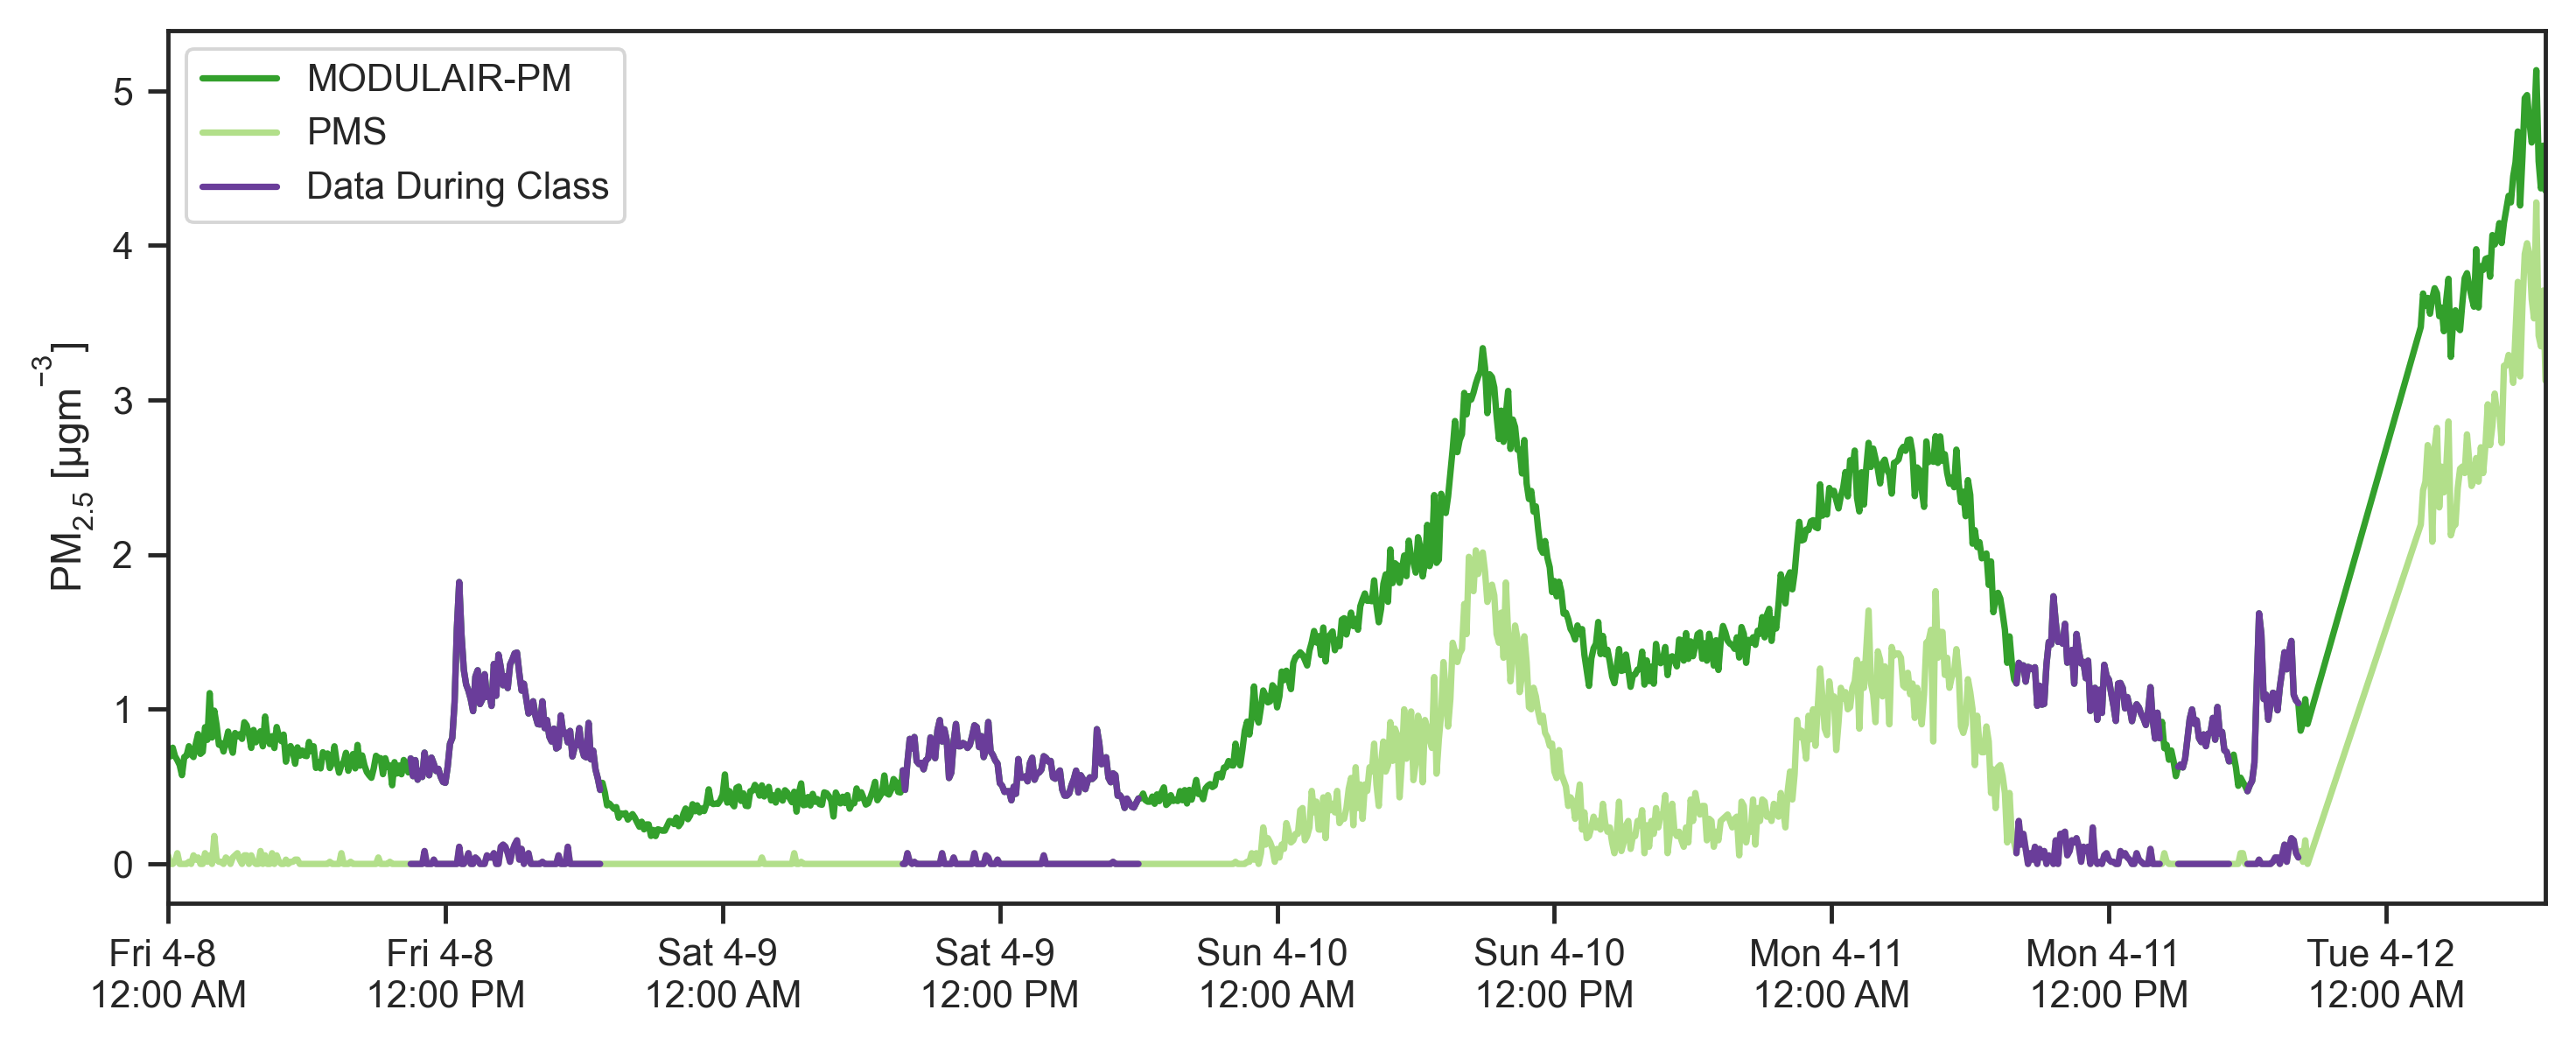

In [39]:
# force 'normal' text style for math text
mpl.rcParams['mathtext.default'] = 'regular'

def x_major_ticks(x, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    x = mdates.num2date(x)
    fmt = "%a %-m-%-d \n%I:%M %p"
    
    return x.strftime(fmt)

def y_major_ticks(y, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    y = int(y)
    
    return y

# set global seaborn params
sns.set("paper", "ticks", color_codes=True, palette='Paired')

# set up the matplotlib figure
fig, ax = plt.subplots(figsize = [8.5, 3.5], dpi = 350)

# grab the current color palette
cmap = sns.color_palette("Paired")

# plot the PM1 data
plt.plot(data['PM25_modpm'], lw=1.5, label="MODULAIR-PM", color=cmap[3])
plt.plot(data['PM25_neph'], lw=1.5, label='PMS', color=cmap[2])

# overlay class time
plt.plot(data['PM25_modpm'].where(data['obseved_class']==1,  other =np.nan), lw=1.5, label = 'Data During Class', color=cmap[9])
plt.plot(data['PM25_neph'].where(data['obseved_class']==1,  other =np.nan), lw=1.5, label=None, color=cmap[9])

plt.ylabel("$PM_{2.5} \; [\mu g m^{-3}]$")
plt.xlim('04-08-2022 00:00', '04-12-2022 06:54')
plt.legend(loc = 'upper left')

ax.xaxis.set_major_formatter(x_major_ticks)
ax.yaxis.set_major_formatter(y_major_ticks)

# force a tight layout
plt.tight_layout()

# save the figure
plt.savefig(
    folder + "Timeseries_PM25_Class.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)

# plt.close(fig)

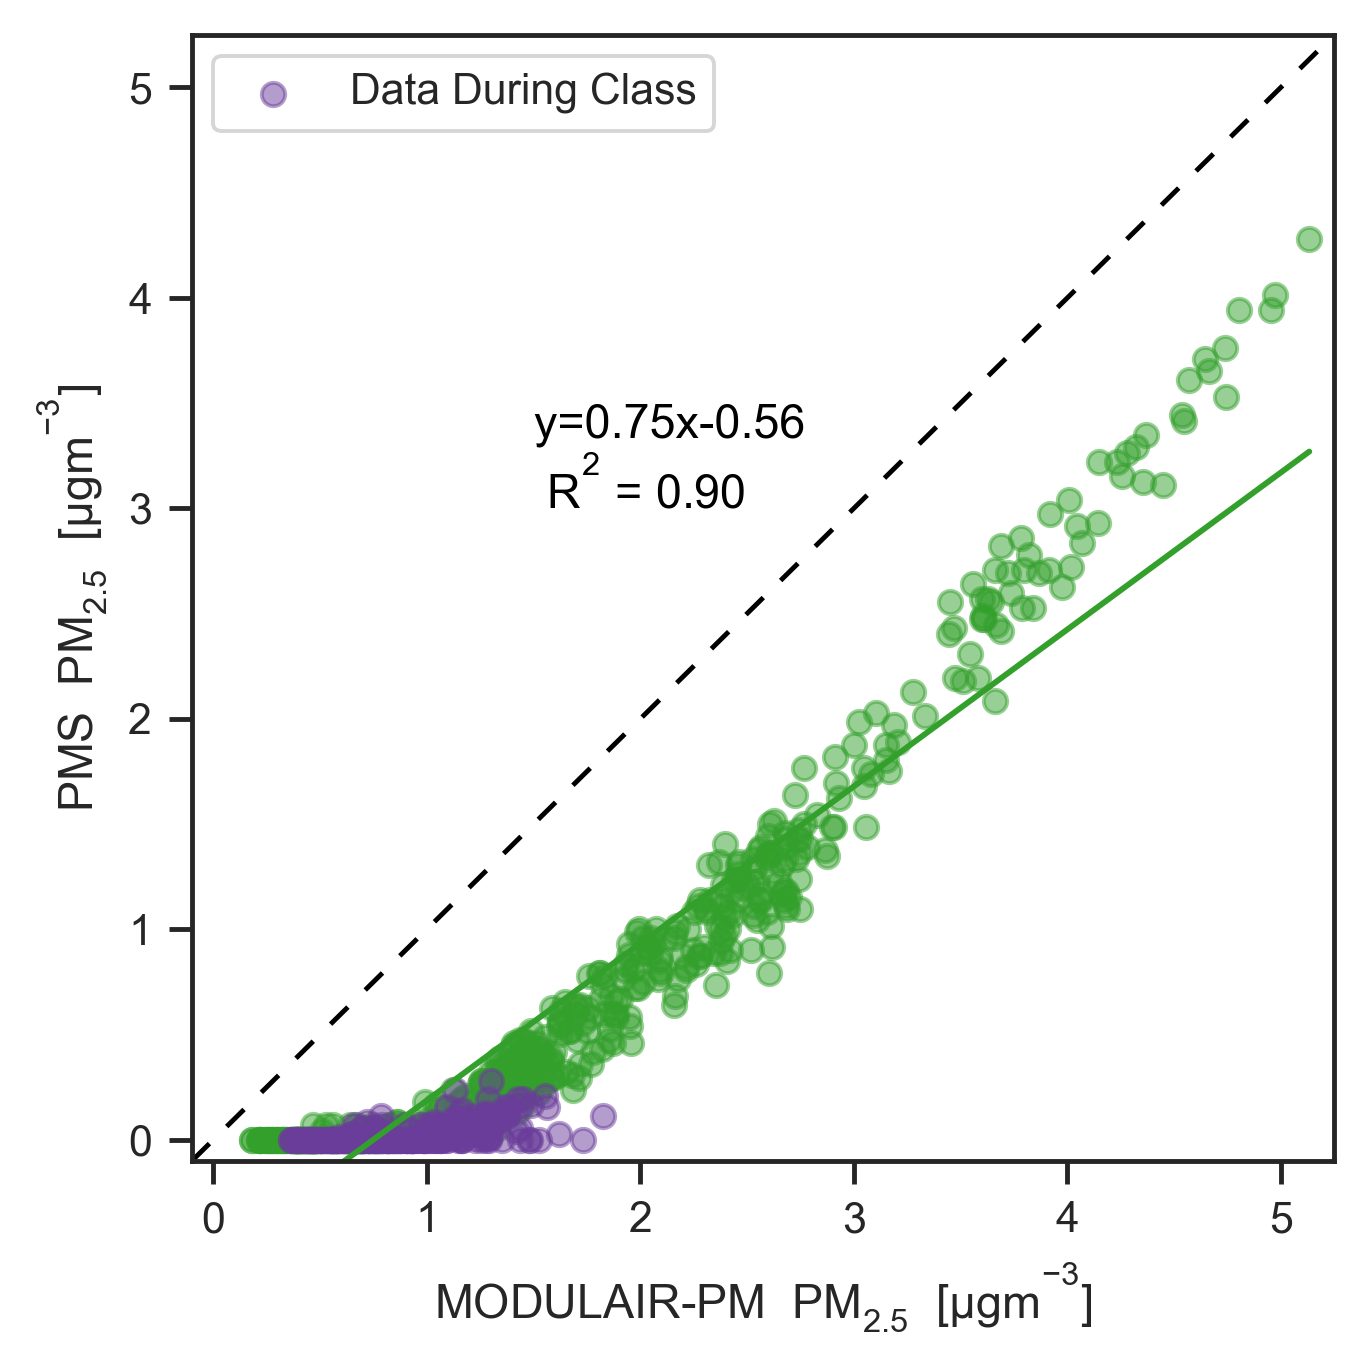

In [42]:
fig = plt.figure(figsize = [4, 4], dpi = 350)

cmap = sns.color_palette("Paired")

# Add scatter points
plt.scatter(
    data["PM25_modpm"].where(data['obseved_class']==0), 
    data["PM25_neph"].where(data['obseved_class']==0), 
    marker = MarkerStyle('o'),
    alpha = 0.5,
    color = cmap[3],
    label = None)

# Add Class Coloring
plt.scatter(
    data["PM25_modpm"].where(data['obseved_class']==1,  other =np.nan), 
    data["PM25_neph"].where(data['obseved_class']==1,  other =np.nan), 
    marker = MarkerStyle('o'),
    alpha = 0.5,
    color = cmap[9],
    label = 'Data During Class')

# Add x=y line
plt.axline(
    [0, 0],
    [1, 1],
    c = 'black',
    dashes = (5, 5), lw= 1)

# Add ols trendline
plt.plot(
    x_modpm_pm25,
    y_neph_pm25,
    color = cmap[3])

plt.xlabel("MODULAIR-PM  " + "$PM_{2.5}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylabel("PMS  " + "$PM_{2.5}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylim(-0.1, 5.25)
plt.xlim(-0.1, 5.25)
plt.annotate('y=0.75x-0.56 \n $R^2$ = 0.90', (1.5,3), c = 'black')
plt.legend(loc = 'upper left')

plt.tight_layout()


plt.savefig(
    folder + "Scatter_PM25_Class.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
# plt.close(fig)

### 2.4.3 PM10

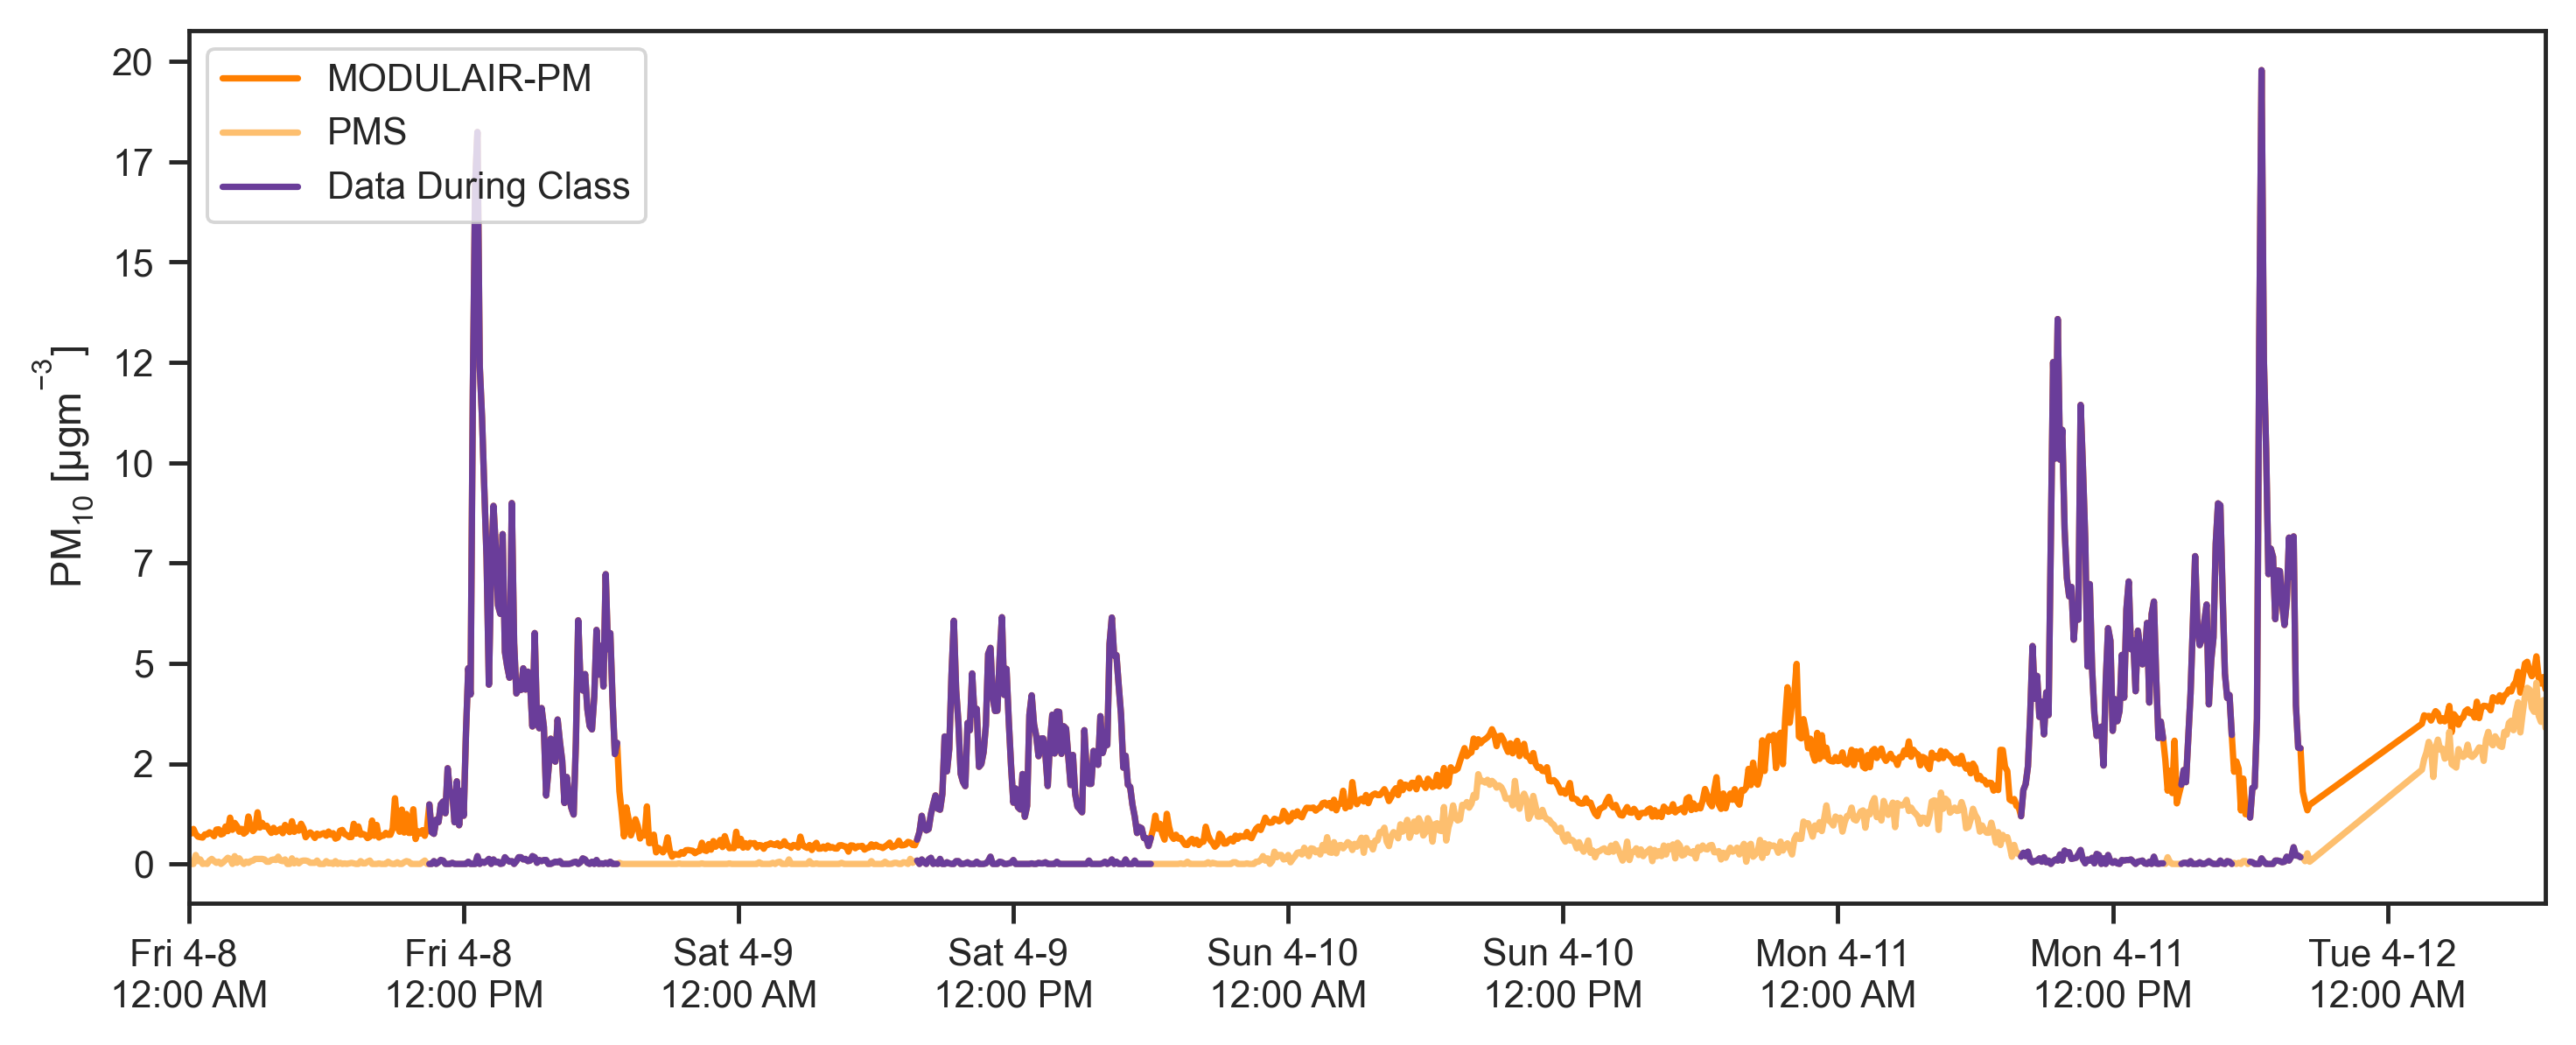

In [40]:
# force 'normal' text style for math text
mpl.rcParams['mathtext.default'] = 'regular'

def x_major_ticks(x, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    x = mdates.num2date(x)
    fmt = "%a %-m-%-d \n%I:%M %p"
    
    return x.strftime(fmt)

def y_major_ticks(y, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    y = int(y)
    
    return y

# set global seaborn params
sns.set("paper", "ticks", color_codes=True, palette='Paired')

# set up the matplotlib figure
fig, ax = plt.subplots(figsize = [8.5, 3.5], dpi = 350)

# grab the current color palette
cmap = sns.color_palette("Paired")

# plot the PM1 data
plt.plot(data['PM10_modpm'], lw=1.5, label="MODULAIR-PM", color=cmap[7])
plt.plot(data['PM10_neph'], lw=1.5, label='PMS', color=cmap[6])

# overlay class time
plt.plot(data['PM10_modpm'].where(data['obseved_class']==1,  other =np.nan), lw=1.5, label = 'Data During Class', color=cmap[9])
plt.plot(data['PM10_neph'].where(data['obseved_class']==1,  other =np.nan), lw=1.5, label=None, color=cmap[9])

plt.ylabel("$PM_{10} \; [\mu g m^{-3}]$")
plt.xlim('04-08-2022 00:00', '04-12-2022 06:54')
plt.legend(loc = 'upper left')

ax.xaxis.set_major_formatter(x_major_ticks)
ax.yaxis.set_major_formatter(y_major_ticks)

# force a tight layout
plt.tight_layout()

# save the figure
plt.savefig(
    folder + "Timeseries_PM10_Class.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)

# plt.close(fig)

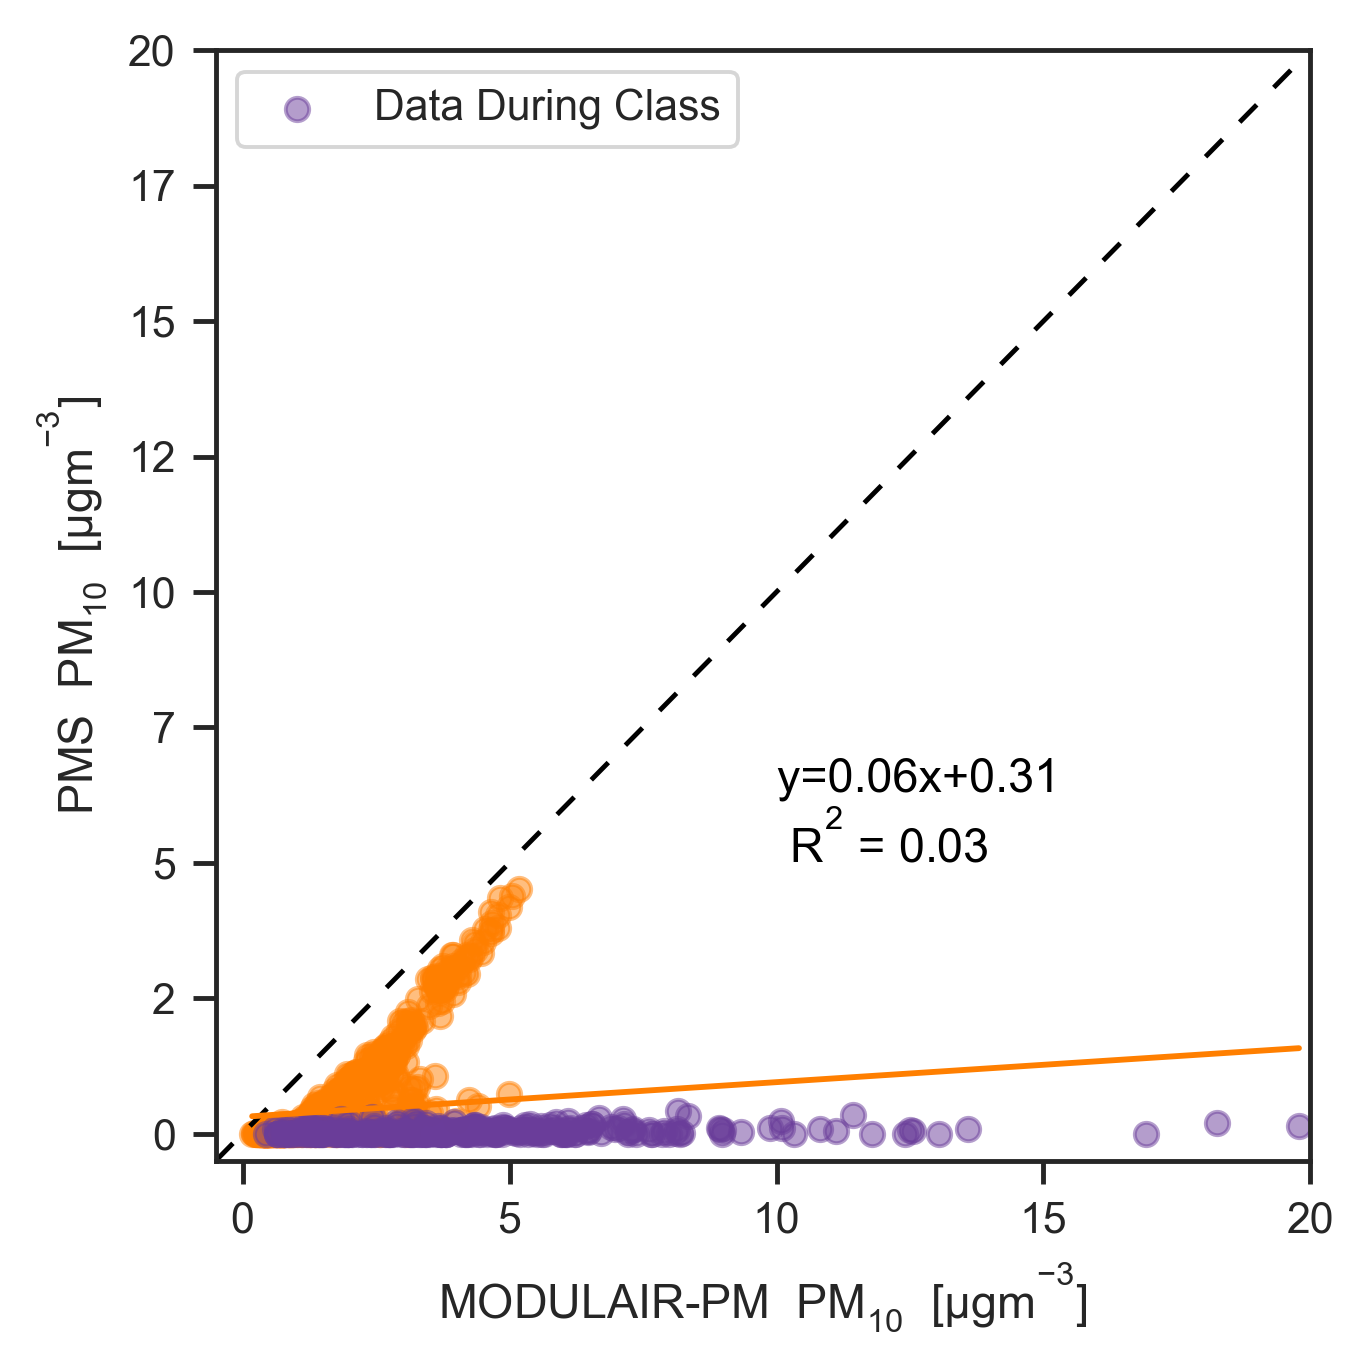

In [43]:
fig, ax = plt.subplots(figsize = [4, 4], dpi = 350)

cmap = sns.color_palette("Paired")

# Add scatter points
plt.scatter(
    data["PM10_modpm"].where(data['obseved_class']==0), 
    data["PM10_neph"].where(data['obseved_class']==0), 
    marker = MarkerStyle('o'),
    alpha = 0.5,
    color = cmap[7],
    label = None)

# Add Class Coloring
plt.scatter(
    data["PM10_modpm"].where(data['obseved_class']==1,  other =np.nan), 
    data["PM10_neph"].where(data['obseved_class']==1,  other =np.nan), 
    marker = MarkerStyle('o'),
    alpha = 0.5,
    color = cmap[9],
    label = 'Data During Class')

# Add x=y line
plt.axline(
    [0, 0],
    [1, 1],
    c = 'black',
    dashes = (5, 5), lw= 1)

# Add ols trendline
plt.plot(
    x_modpm_pm10,
    y_neph_pm10,
    color = cmap[7])

plt.xlabel("MODULAIR-PM  " + "$PM_{10}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylabel("PMS  " + "$PM_{10}$" + "  " +"$[\mu g m^{-3}]$")
plt.ylim(-0.5, 20)
plt.xlim(-0.5, 20)
plt.annotate('y=0.06x+0.31 \n $R^2$ = 0.03', (10,5), c = 'black')
plt.legend(loc = 'upper left')

ax.yaxis.set_major_formatter(y_major_ticks)

plt.tight_layout()


plt.savefig(
    folder + "Scatter_PM10_Class.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
# plt.close(fig)

## 2.5 Bias Plots 

### 2.5.1 Geo. Mean Diameter (GM)

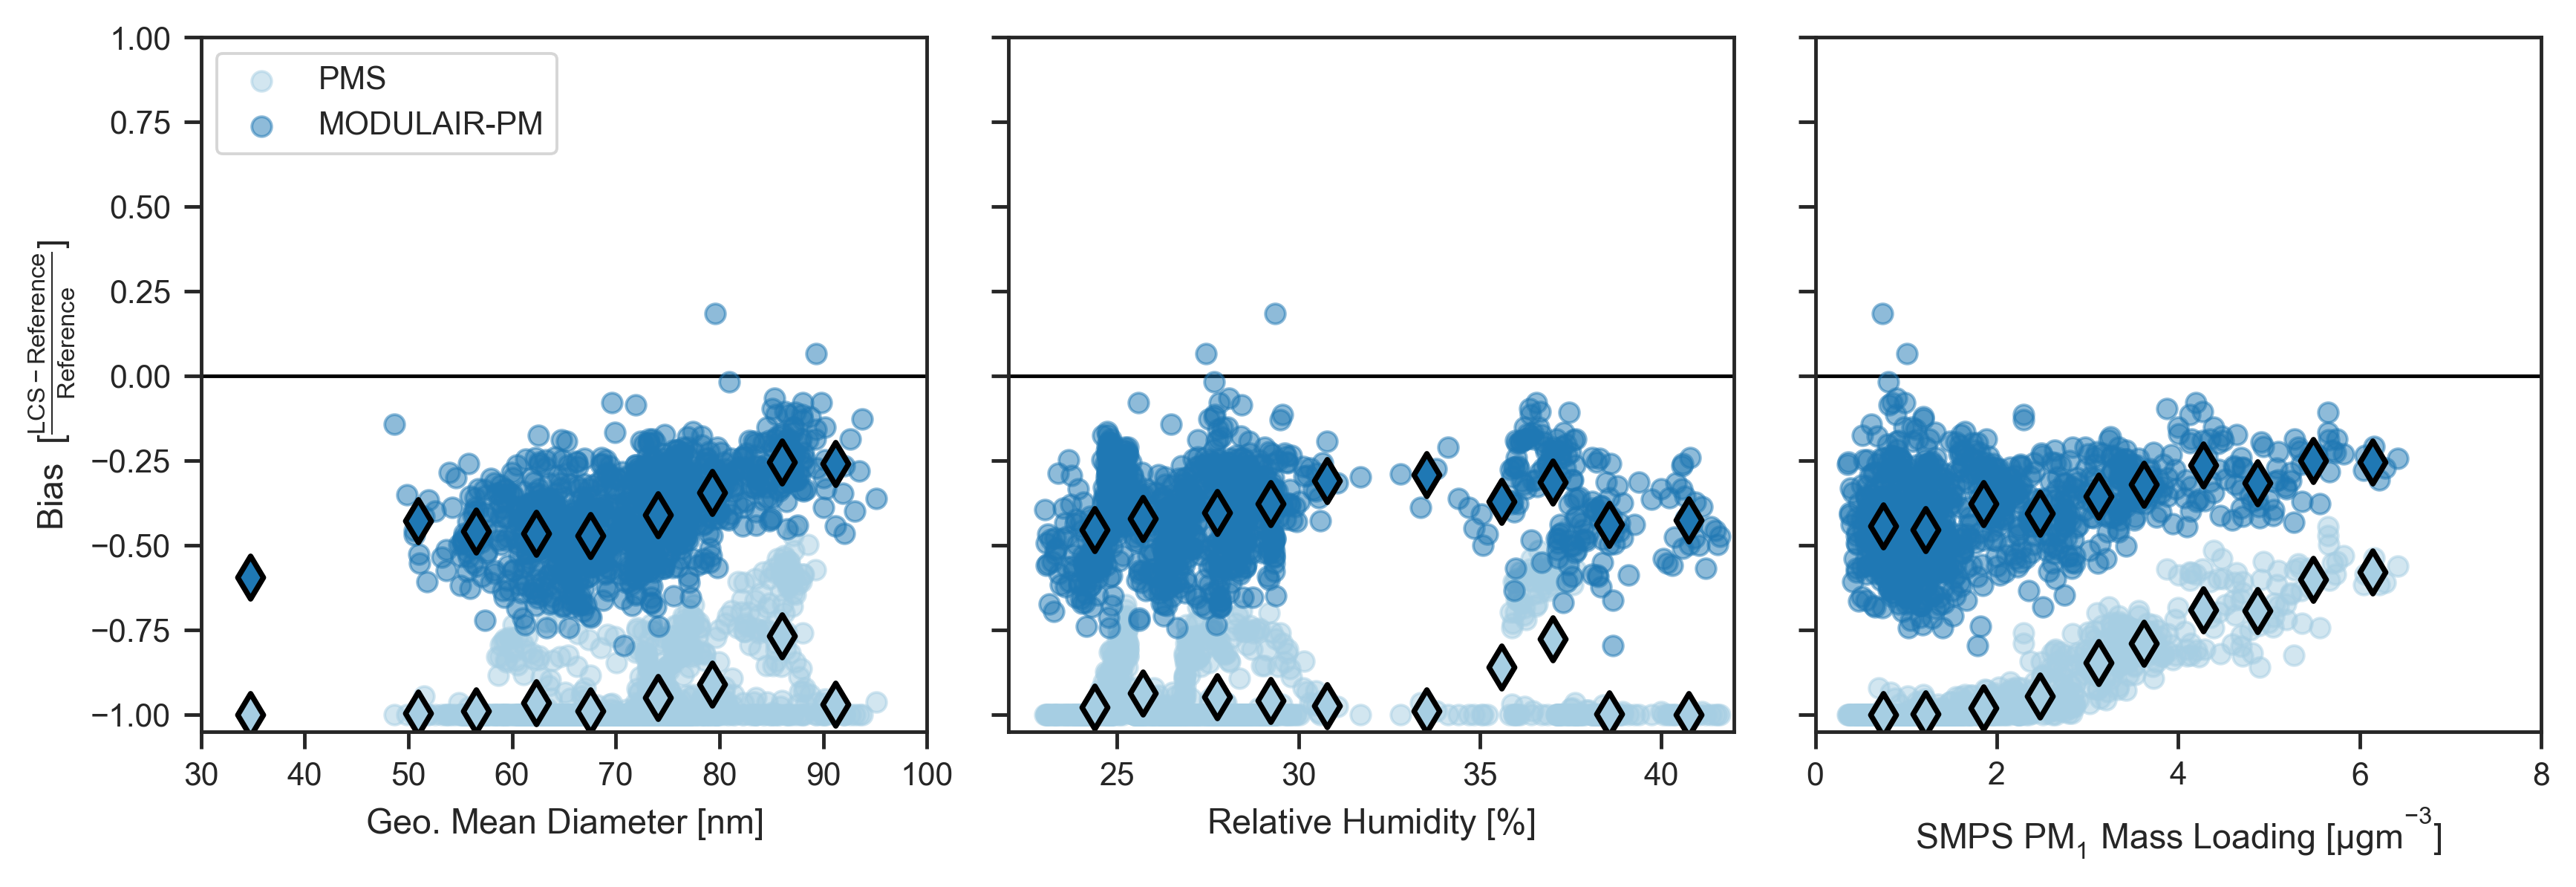

In [594]:
from matplotlib.markers import MarkerStyle

# Create temporary df to combine timeseries data and bias plot data
    # Columns need to have sampe dimensions to plot on same graph
tmp = data.copy()[["Geo. Mean (nm)", "PMS PM1 bias", "modpm PM1 bias", 'rh', 'PM1_SMPS']]

# Add gm data: first create empty column in tmp, then fill empty column w gm values
tmp['gm_group'] = pd.Series([np.nan]*tmp.shape[0])
tmp['gm_group'].iloc[0:gm.shape[0]] = gm["Geo. Mean (nm)"]
tmp['PMS_bias_gm'] = pd.Series([np.nan]*tmp.shape[0])
tmp['PMS_bias_gm'].iloc[0:gm.shape[0]] = gm["PMS PM1 bias"]
tmp['modpm_bias_gm'] = pd.Series([np.nan]*tmp.shape[0])
tmp['modpm_bias_gm'].iloc[0:gm.shape[0]] = gm["modpm PM1 bias"]

# Add rh data
tmp['rh_group'] = pd.Series([np.nan]*tmp.shape[0])
tmp['rh_group'].iloc[0:rh.shape[0]] = rh["rh"]
tmp['PMS_bias_rh'] = pd.Series([np.nan]*tmp.shape[0])
tmp['PMS_bias_rh'].iloc[0:rh.shape[0]] = rh["PMS PM1 bias"]
tmp['modpm_bias_rh'] = pd.Series([np.nan]*tmp.shape[0])
tmp['modpm_bias_rh'].iloc[0:rh.shape[0]] = rh["modpm PM1 bias"]

# Add ml data
tmp['ml_group'] = pd.Series([np.nan]*tmp.shape[0])
tmp['ml_group'].iloc[0:ml.shape[0]] = ml["PM1_SMPS"]
tmp['PMS_bias_ml'] = pd.Series([np.nan]*tmp.shape[0])
tmp['PMS_bias_ml'].iloc[0:ml.shape[0]] = ml["PMS PM1 bias"]
tmp['modpm_bias_ml'] = pd.Series([np.nan]*tmp.shape[0])
tmp['modpm_bias_ml'].iloc[0:ml.shape[0]] = ml["modpm PM1 bias"]

# set global seaborn params
sns.set("paper", "ticks", color_codes=True, palette='Paired')

# set up the matplotlib figure
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), dpi = 350, edgecolor  = 'black', sharex=False, sharey=True)

# grab the current color palette
cmap = sns.color_palette("Paired")

# plot the gm data
ax[0].axhline(lw = 1, color='black', zorder = 0)
ax[0].scatter(tmp["Geo. Mean (nm)"], tmp['PMS PM1 bias'], s = 30, marker = MarkerStyle('o'), alpha = 0.5, label="PMS", color=cmap[0])
ax[0].scatter(tmp["gm_group"], tmp['PMS_bias_gm'], s = 70, marker = 'd', label=None, edgecolors='black', lw = 1.5, color=cmap[0])
ax[0].scatter(tmp["Geo. Mean (nm)"], tmp['modpm PM1 bias'], s=30, marker = MarkerStyle('o'), alpha = 0.5, label="MODULAIR-PM", color=cmap[1])
ax[0].scatter(tmp["gm_group"], tmp['modpm_bias_gm'], s = 70, marker = 'd', edgecolors='black', label=None, lw = 1.5, color=cmap[1])
ax[0].set_ylabel("Bias  " + r'$[\frac{LCS-Reference}{Reference}]$')
ax[0].set_xlabel("Geo. Mean Diameter " + "$[nm]$")
ax[0].set_ylim(-1.05, 1)
ax[0].set_xlim(30, 100)

# plot the rh data
ax[1].axhline(lw = 1, color='black', zorder = 0)
ax[1].scatter(tmp["rh"], tmp['PMS PM1 bias'], s = 30, marker = MarkerStyle('o'), alpha = 0.5, label="PMS", color=cmap[0])
ax[1].scatter(tmp["rh_group"], tmp['PMS_bias_rh'], s = 70, marker = 'd', label="PMS", edgecolors='black', lw = 1.5, color=cmap[0])
ax[1].scatter(tmp["rh"], tmp['modpm PM1 bias'], s=30, marker = MarkerStyle('o'), alpha = 0.5, label="MODULAIR-PM", color=cmap[1])
ax[1].scatter(tmp["rh_group"], tmp['modpm_bias_rh'], s = 70, marker = 'd', edgecolors='black', label="PMS", lw = 1.5, color=cmap[1])
ax[1].set_xlabel("Relative " + "Humidity " + "$[\%]$")
ax[1].set_ylim(-1.05, 1)
ax[1].set_xlim(22, 42)

# plot the ml data
ax[2].axhline(lw = 1, color='black', zorder = 0)
ax[2].scatter(tmp["PM1_SMPS"], tmp['PMS PM1 bias'], s = 30,marker = MarkerStyle('o'), alpha = 0.5, label="PMS", color=cmap[0])
ax[2].scatter(tmp["ml_group"], tmp['PMS_bias_ml'], s = 70, marker = 'd', label="PMS", edgecolors='black', lw = 1.5, color=cmap[0])
ax[2].scatter(tmp["PM1_SMPS"], tmp['modpm PM1 bias'], s=30, marker = MarkerStyle('o'), alpha = 0.5, label="MODULAIR-PM", color=cmap[1])
ax[2].scatter(tmp["ml_group"], tmp['modpm_bias_ml'], s = 70, marker = 'd', edgecolors='black', label="PMS", lw = 1.5, color=cmap[1])
ax[2].set_xlabel("SMPS " +  "$PM_1$" + " Mass Loading " +  "$[\mu g m^{-3}]$")
ax[2].set_ylim(-1.05, 1)
ax[2].set_xlim(0, 8)

plt.tight_layout()

ax[0].legend(loc = 'upper left')

plt.savefig(
    folder + "Bias.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)

## 2.6 SMPS PM1 dNdlogDp

### 2.6.1 Whole period

In [595]:
fig, ax = plt.subplots(figsize = [5, 3.5], dpi = 350)

def y_major_ticks(y, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    y = int(float(y)*1000)
    
    return y

numerator1 = obj.dndlogdp.mean()
denominator1 = obj.dndlogdp.mean().sum()

plt.scatter(
    x=obj.midpoints,
    y= numerator1/denominator1,
    color='darkgray')

plt.xscale('log')
plt.ylim(0, 0.025)
plt.xlabel("${D}_p  [nm]$")
plt.ylabel("${dN/dlogD}_p$")

ax.xaxis.set_major_formatter(y_major_ticks)

plt.tight_layout()

plt.savefig(
    folder + "SMPS dNdlogDp.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)

plt.close(fig)

### Classes

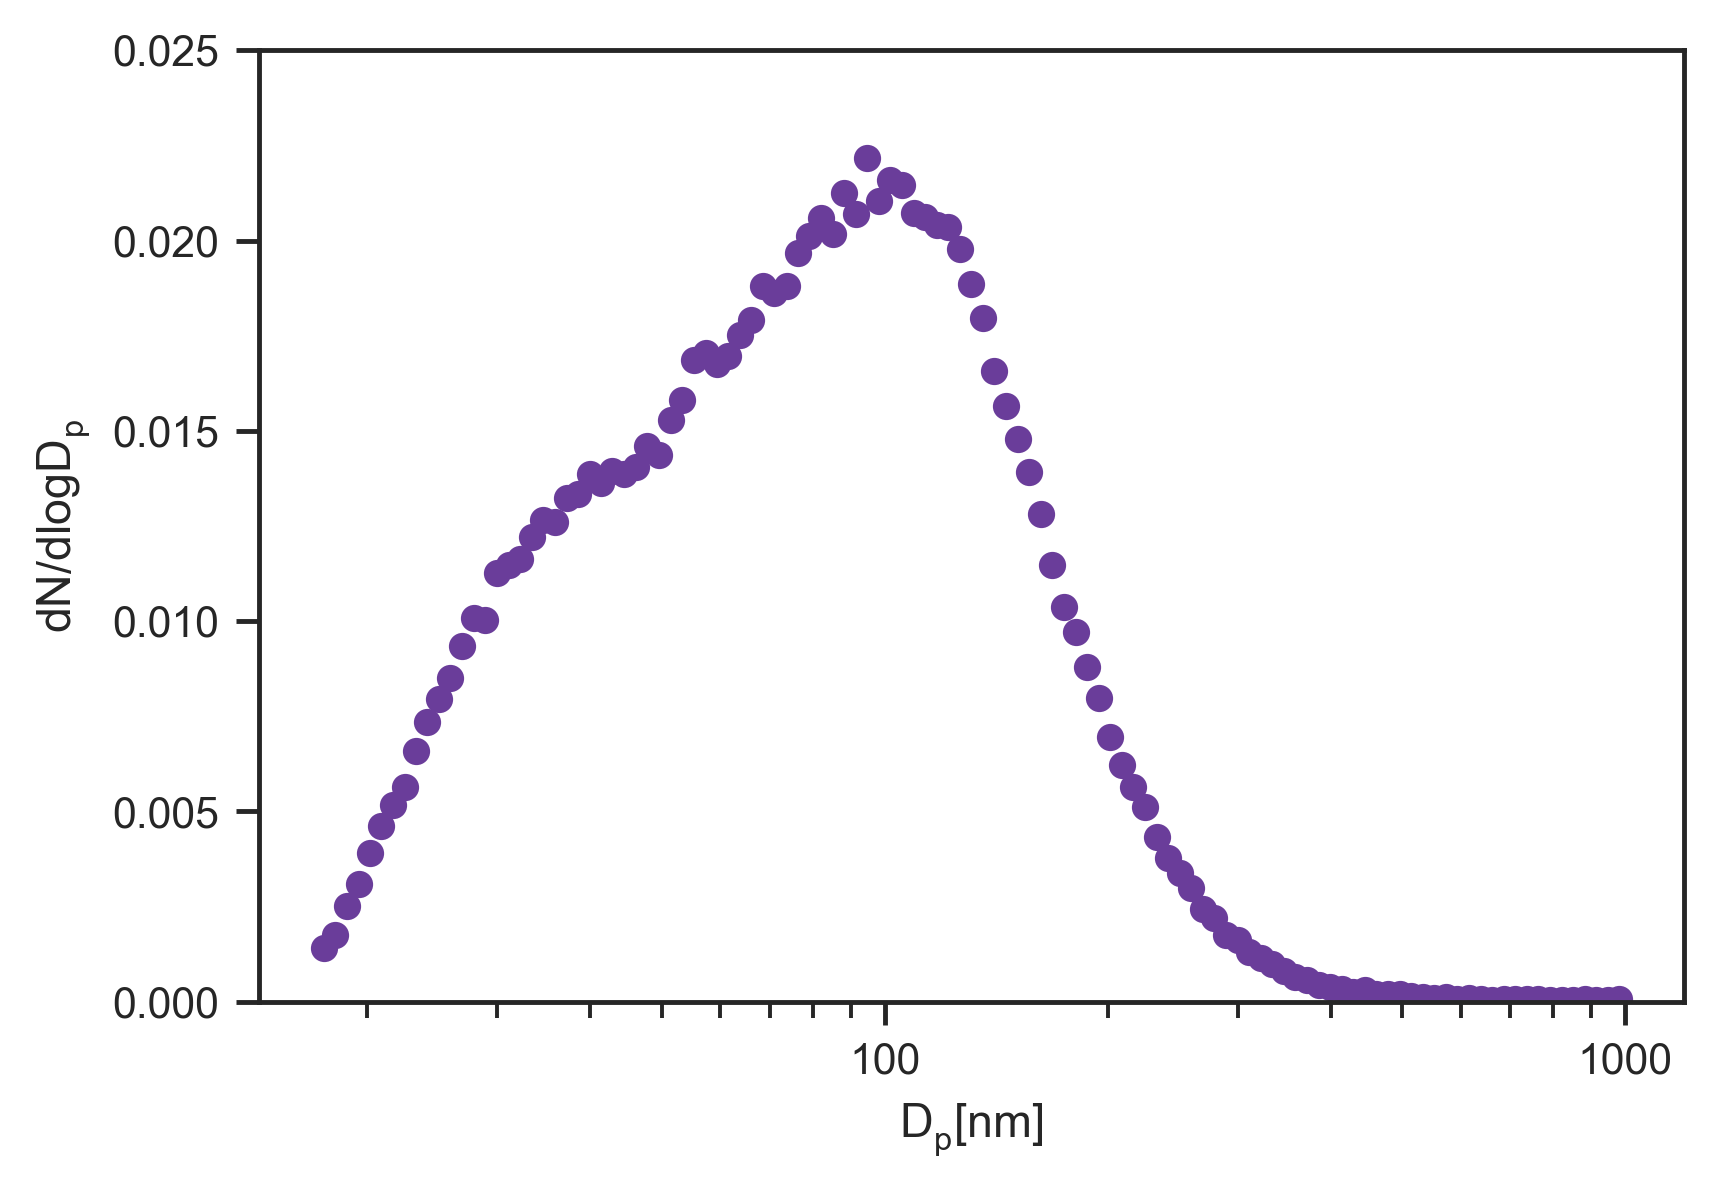

In [44]:
folder = "/Users/zahrashivji/Dropbox/Shivji/Final Figures/Indoor/"

group = data.where(data['obseved_class']==1,  other =np.nan).dropna()

#Build a generic Particle Sizer Object 
obj = smps.GenericParticleSizer(
    data=df2.loc[group.index].copy(),
    bins=bins,
    fmt='dn',
    dp_units='nm',
    bin_labels=binlabels
)

fig, ax = plt.subplots(figsize = [5, 3.5], dpi = 350)

def y_major_ticks(y, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    y = int(float(y)*1000)
    
    return y

numerator1 = obj.dndlogdp.mean()
denominator1 = obj.dndlogdp.mean().sum()

plt.scatter(
    x=obj.midpoints,
    y= numerator1/denominator1,
    color=cmap[9])

plt.xscale('log')
plt.ylim(0, 0.025)
plt.xlabel("${D}_p  [nm]$")
plt.ylabel("${dN/dlogD}_p$")

ax.xaxis.set_major_formatter(y_major_ticks)

plt.tight_layout()

plt.savefig(
    folder + "SMPS dNdlogDp_Class.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)

# plt.close(fig)

## 2.7 Size Bins Fractions

In [71]:
folder = "/Users/zahrashivji/Dropbox/Shivji/Final Figures/Indoor/"

# fig, ax = plt.subplots(nrows = 1, ncols = 2, dpi = 350, figsize = [4, 2], sharey = True)

# x values
x = ['$PM_{1}$', '$PM_{2.5}$', '$PM_{10}$']

# Calculate modpm fracs
pm1_modpm = data['PM1_modpm'].mean()
pm25_modpm =  (data['PM25_modpm']-data['PM1_modpm']).mean()
pm10_modpm = (data['PM10_modpm']-data['PM25_modpm']).mean()

total_modpm = pm1_modpm + pm25_modpm + pm10_modpm

pm1_modpm = pm1_modpm/total_modpm*100
pm25_modpm = pm25_modpm/total_modpm*100
pm10_modpm = pm10_modpm/total_modpm*100

height_modpm = [pm1_modpm, pm25_modpm, pm10_modpm]

# Calculate neph fracs
pm1_neph = data['PM1_neph'].mean()
pm25_neph =  (data['PM25_neph']-data['PM1_neph']).mean()
pm10_neph = (data['PM10_neph']-data['PM25_neph']).mean()

total_neph = pm1_neph + pm25_neph + pm10_neph

pm1_neph = pm1_neph/total_neph*100
pm25_neph = pm25_neph/total_neph*100
pm10_neph = pm10_neph/total_neph*100

height_neph = [pm1_neph, pm25_neph, pm10_neph]

height = list(zip(height_modpm, height_neph))

# ax[0].bar(x, height, width=0.7, color = [cmap[1], cmap[3], cmap[7]])
# # ax[1].bar(x, height_neph, width=0.7, color = [cmap[0], cmap[2], cmap[6]])

# ax[0].set_title('MODULAIR-PM')
# # ax[1].set_title('PMS')
# ax[0].set_ylabel('Percent [%]')
# ax[0].set_ylim(0,100)

# plt.tight_layout()

# plt.savefig(
#     folder + "PM_fractions.png",
#     format = 'png',
#     dpi='figure',
#     edgecolor='black',
#     transparent = True)

# plt.close(fig)
height_modpm

[47.682368365107806, 4.925258764479383, 47.392372870412814]

# 3. Calculations

## 3.1 % Reporting "0 ug/m3"

### 3.1.1 PMS

In [54]:
neph_0 = data['PM1_neph'].where(data['PM1_neph']==0, other = np.nan).dropna()
neph_only = data['PM1_neph'].dropna()
neph_0_PM1 = neph_0.shape[0] / neph_only.shape[0]
neph_0_PM1

0.59979633401222

In [55]:
neph_0 = data['PM25_neph'].where(data['PM25_neph']==0, other = np.nan).dropna()
neph_only = data['PM25_neph'].dropna()
neph_0_PM25 = neph_0.shape[0] / neph_only.shape[0]
neph_0_PM25

0.46028513238289204

In [56]:
neph_0 = data['PM10_neph'].where(data['PM10_neph']==0, other = np.nan).dropna()
neph_only = data['PM10_neph'].dropna()
neph_0_PM10 = neph_0.shape[0] / neph_only.shape[0]
neph_0_PM10

0.3228105906313646

### 3.1.2 MODULAIR-PM

In [57]:
modpm_0 = data['PM1_modpm'].where(data['PM1_modpm']==0, other = np.nan).dropna()
modpm_only = data['PM1_modpm'].dropna()
modpm_0_PM1 = modpm_0.shape[0] / modpm_only.shape[0]
modpm_0_PM1

0.0

## 3.2 LOD

In [ ]:
# std of reference @ "blank" conditions
    # blank conditions --> reading < 1ug.m3 (ambient)
o_bulk = data['PM1_SMPS'].where(data['PM1_SMPS'] < 1, other = np.nan).dropna() #304 readings
o_bulk_std = o_bulk.std()

### 3.2.1 PMS

In [61]:
k_neph = 0.3569
LOD_neph = 3*o_bulk_std/k_neph
LOD_neph

1.2507043216005775

### 3.2.2 MODULAIR-PM

In [62]:
k_modpm = 0.7378
LOD_modpm = 3*o_bulk_std/k_modpm
LOD_modpm

0.6050099923817377

### 3.2.3 PM1 timeseies with LOD

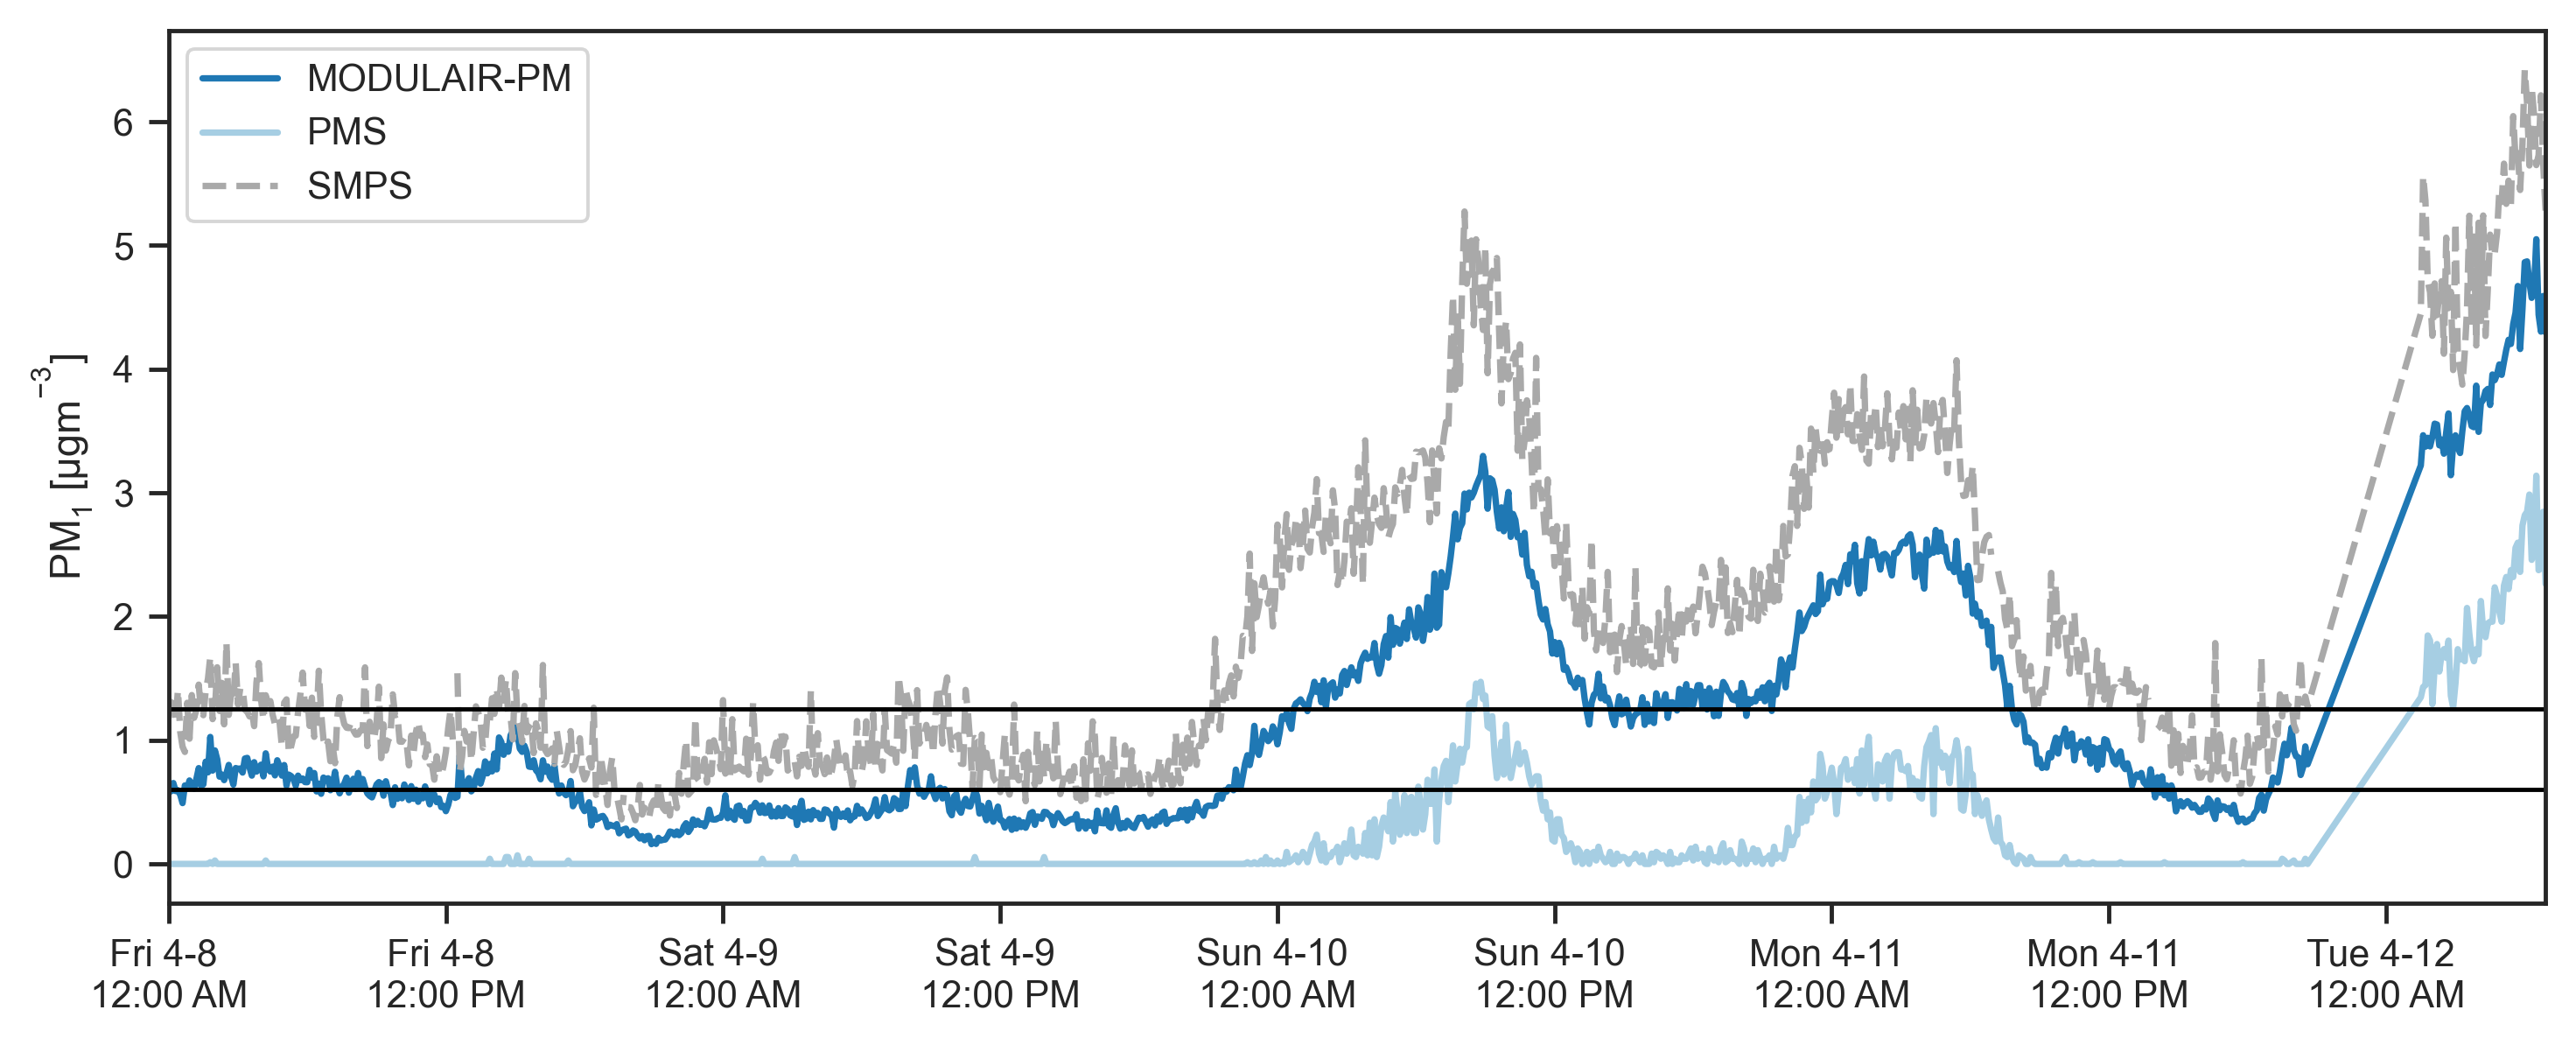

In [65]:
# # set the label fontsize
# xy_label_fontsize = 12

# force 'normal' text style for math text
mpl.rcParams['mathtext.default'] = 'regular'

def x_major_ticks(x, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    x = mdates.num2date(x)
    fmt = "%a %-m-%-d \n%I:%M %p"
    
    return x.strftime(fmt)

def y_major_ticks(y, pos=None):
    """Set the major ticks according 
    to this custom style
    """
    y = int(y)
    
    return y

# set global seaborn params
sns.set("paper", "ticks", color_codes=True, palette='Paired')

# set up the matplotlib figure
fig, ax = plt.subplots(figsize = [8.5, 3.5], dpi = 350)

# grab the current color palette
cmap = sns.color_palette("Paired")

# plot the PM1 data
plt.plot(data['PM1_modpm'], lw=1.5, label="MODULAIR-PM", color=cmap[1])
plt.plot(data['PM1_neph'], lw=1.5, label='PMS', color=cmap[0])
plt.plot(data['PM1_SMPS'], lw=1.5, label='SMPS', color='darkgray', linestyle='dashed')
plt.ylabel("$PM_{1} \; [\mu g m^{-3}]$")
plt.xlim('04-08-2022 00:00', '04-12-2022 06:54')
plt.legend(loc = 'upper left')

# Add neph LOD line
ax.axhline(LOD_neph, lw = 1, color='black')

# Add modpm LOD line
ax.axhline(LOD_modpm, lw = 1, color='black')

ax.xaxis.set_major_formatter(x_major_ticks)
ax.yaxis.set_major_formatter(y_major_ticks)

# # remove the tiop and right spine
# sns.despine()

# force a tight layout
plt.tight_layout()

# save the figure
plt.savefig(
    folder + "Timeseries_PM1_LOD.png",
    format = 'png',
    dpi='figure',
    edgecolor='black',
    transparent = True)
# plt.close(fig)

In [72]:
data['PM1_SMPS'].mean()

1.871640214079933